## Vigilando la calidad del agua desde el cielo

Ejemplo didáctico usando imágenes monobanda de Landsat8 para detectar con K-MEANS una masa de agua (embalse de la Cuerda del Pozo, Soria, España) y en una segunda iteración, zonas con diferentes calidades de agua en su interior.

A continuación se obtienen las zonas detectadas con el algortimo de Canny, así como las bandas espectrales de dos secciones de una de las escenas, y la firma espectral de un punto a lo largo de las cuatro escenas.

Para ejecutarlo, los datos se deben poner en sus correspondientes subcarpetas, dentro del directorio donde se encuentra este código.

Preparado para acompañar el artículo homónimo en: https://www.iagua.es/blogs/jose-maria-cuenca-cruz

In [1]:
# Cargo librerias y funciones necesarias
import os
from glob import glob

import itertools

import numpy as np

import rasterio
from rasterio import plot

from osgeo import gdal
from osgeo import ogr
from osgeo import osr

from sklearn import preprocessing
from sklearn.cluster import KMeans

import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

### Exploración del conjunto de imágenes de la primera escena

Por el momento es suficiente trabajar solamente con la primera escena, para explorar los datos disponibles y para obtener una máscara de la lámina de agua correspondiente al embalse lleno que aparece en esta escena.

In [2]:
# Defino lista de bandas del sensor optico descargadas
N_OPTICS_BANDS = 7

# band1  - Aerosol costero, 0.43-0.45\u03BCm
# band2  - Azul, 0.45-0.51\u03BCm
# band3  - Verde, 0.53-0.59\u03BCm
# band4  - Rojo, 0.64-0.64\u03BCm
# band5  - Infrarrojo cercano (NIR), 0.85-0.88\u03BCm
# band6  - Infrarrojo de onda corta (SWIR) 1, 1.57-1.65\u03BCm
# band7  - Infrarrojo de onda corta (SWIR) 2, 2.11-2.29\u03BCm

# Para la primera imagen los archivos de sus bandas comienzan
DATA_FOLDER = '.\Landsat8\LC08_L1TP_201031_20160725_20170322_01_T1_B?.TIF'

'''
fileList = glob(DATA_FOLDER)
print("Lista de archivos de la imagen: \n", fileList)
bandsList = fileList[:N_OPTICS_BANDS]
'''
bandsList = glob(DATA_FOLDER)
print("\nLista de archivos de bandas a usar de la imagen: \n", bandsList)


Lista de archivos de bandas a usar de la imagen: 
 ['.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B1.TIF', '.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B2.TIF', '.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B3.TIF', '.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B4.TIF', '.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B5.TIF', '.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B6.TIF', '.\\Landsat8\\LC08_L1TP_201031_20160725_20170322_01_T1_B7.TIF']


In [3]:
# Cargo todas las bandas en un contenedor múltiple de rasterio. 

# El contenedor solo toma los datos matriciales de las imagenes
# No la matriz de transformacion ni crs, etc

bands = [rasterio.open(bandPath).read()[0] for bandPath in bandsList]


# Compruebo las bandas cargadas en el contenedor
len(bands)

7

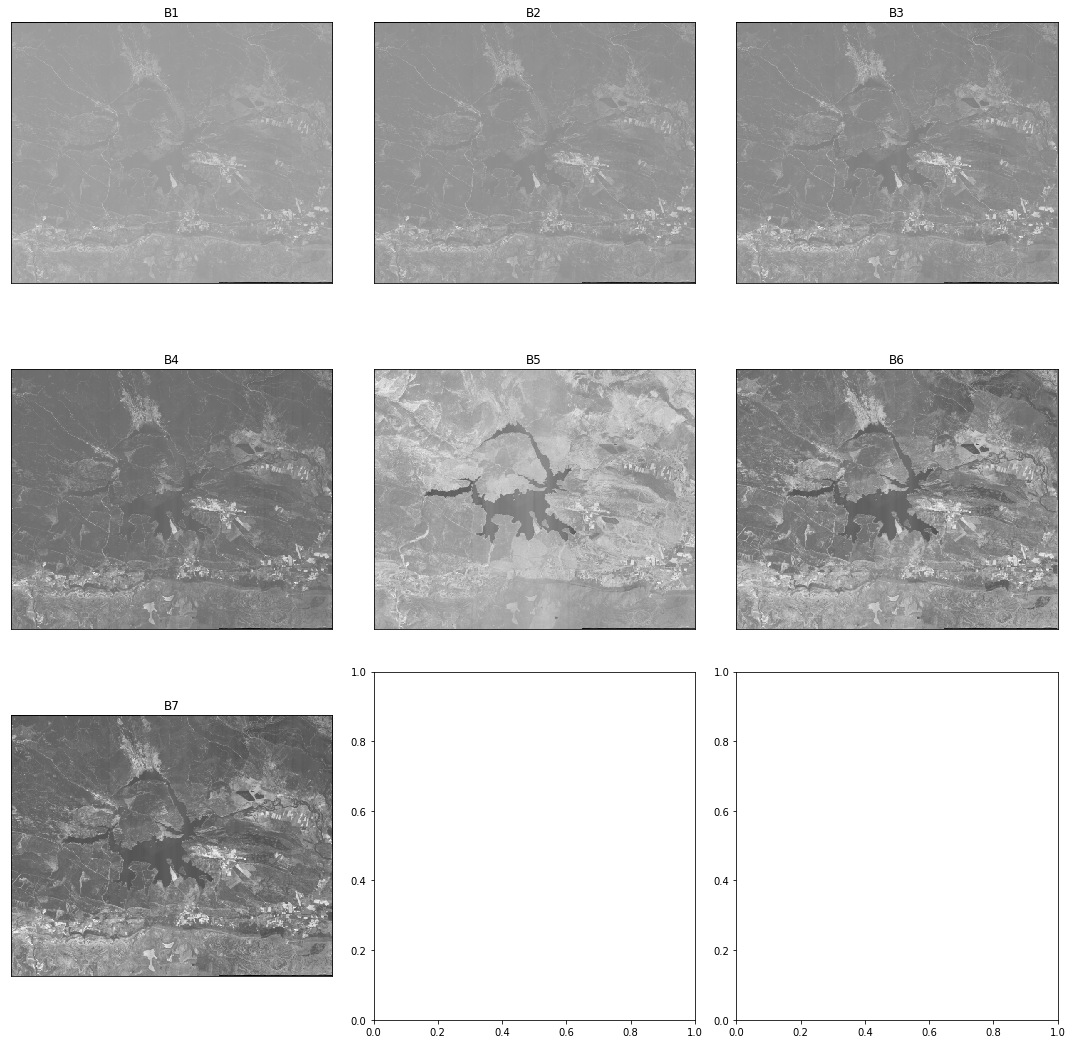

In [4]:
# Mostramos el contenido de cada banda:

axs = range(N_OPTICS_BANDS)

# Defino la figura
fig, axs = plt.subplots(3, 3, figsize=(15,15))

axs = list(itertools.chain.from_iterable(axs))

# Compongo las subfiguras
for b in range(N_OPTICS_BANDS):
    title = "B"+str(b+1)
    # Represento las imagenes
    axs[b].imshow(preprocessing.StandardScaler().fit_transform(bands[b]), cmap="Greys_r")
    
    axs[b].set_xticks([]); axs[b].set_yticks([]); axs[b].set_title(title)

# Muestro la figura
plt.tight_layout(); plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dimensiones RBG:  (628, 774, 3)


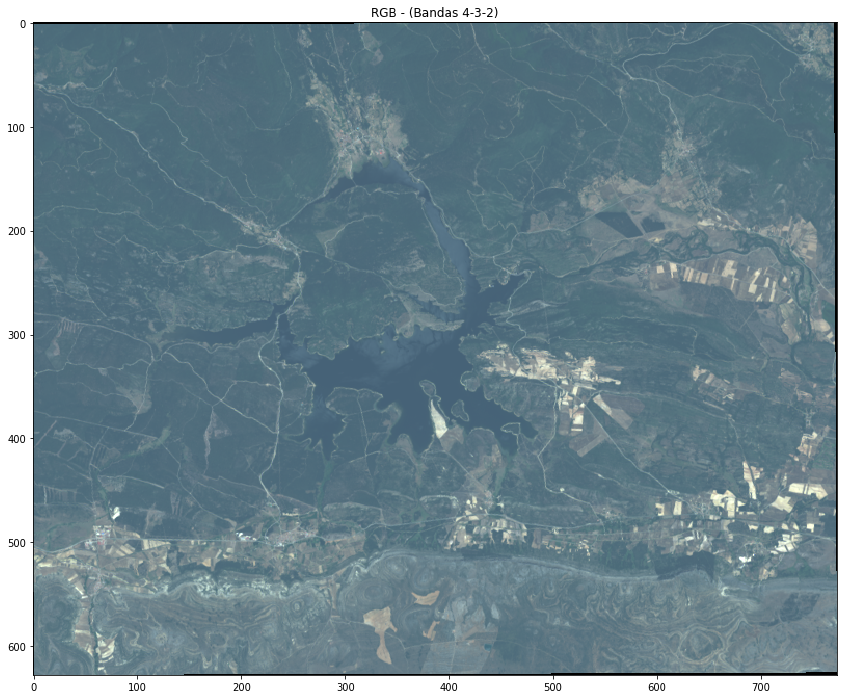

In [5]:
# Creo una composicion en color real mejorada, ajustando BIAS (sesgo global) y ganancia para cada banda
BIAS = 1.3 
GAIN = [0.9, 1, 1.1]

# Extraigo bandas para representacion RGB y reescalo con bias y ganancia
r = (bands[3] - bands[3].min()) / (bands[3].max()-bands[3].min()) * GAIN[0] * BIAS
g = (bands[2] - bands[2].min()) / (bands[2].max()-bands[2].min()) * GAIN[1] * BIAS
b = (bands[1] - bands[1].min()) / (bands[1].max()-bands[1].min()) * GAIN[2] * BIAS

# Creo arreglo numpy con las bandas RGB procesadas
rgbImage = np.zeros((bands[1].shape[0], bands[1].shape[1], 3))
rgbImage[:,:,0] = r
rgbImage[:,:,1] = g
rgbImage[:,:,2] = b
print("Dimensiones RBG: ", rgbImage.shape)

# Muestro la composicion
plt.figure(figsize=(16,12))
plt.imshow(rgbImage)
plt.title("RGB - (Bandas 4-3-2)")
plt.show()


### Grafico de dispersion

Un correlograma representa las posibles correlaciones entre dos variables. Se puede usar para ver cómo una banda se comporta frente a otra. Como todos los objetos del conjunto son de la misma imagen, si se comparan pixel a pixel obtenemos una idea de la relación entre los elementos de la composición (suelo, agua, roca, vegetación...), es decir, de su firma espectral.

Por ejemplo, si comparamos las bandas del rojo y del infrarrojo cercano NIR, el agua tiene una baja representacion en ambas bandas, aparece una correlación muy lineal con el suelo desnudo (se representan parecido), y la vegetación tiene mayor reflectancia en el NIR que en el rojo visible.

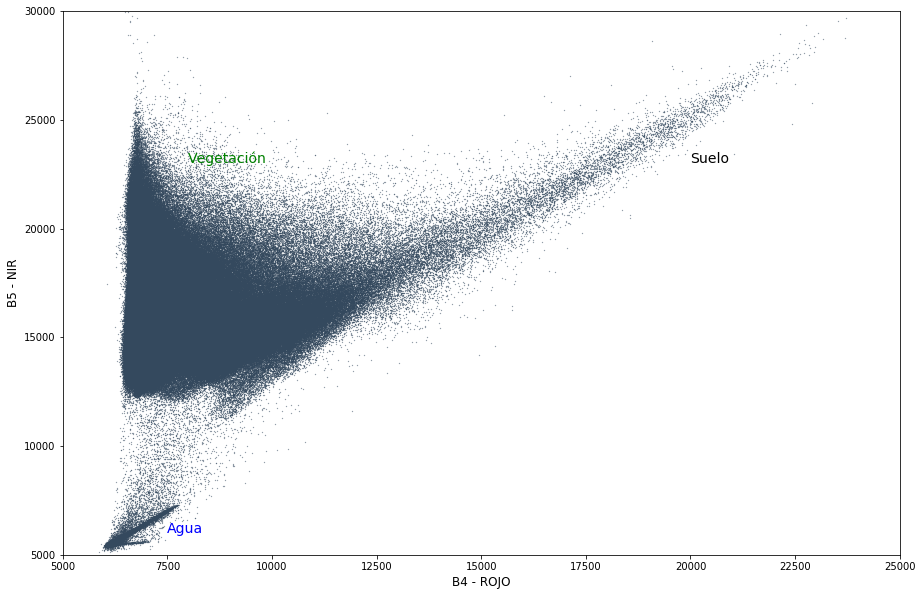

In [6]:
# Represento relacion entre la banda del rojo y la del infrarrojo cercano nir

plt.figure(figsize=(15,10))

plt.scatter(
    x = bands[3].reshape(1,-1)[0], 
    y = bands[4].reshape(1,-1)[0], 
    s = 0.05, color="#34495e")

plt.xlabel('B4 - ROJO', size=12);
plt.ylabel('B5 - NIR', size=12)

plt.xlim(5000,25000)
plt.ylim(5000,30000)

# Añado etiquetas de zonas conocidas
plt.text(7500,6000, 'Agua', fontsize=14, color='blue')
plt.text(8000,23000, 'Vegetación', fontsize=14, color='green')
plt.text(20000,23000, 'Suelo', fontsize=14)

plt.show()


## Clasificación de datos con k-means 

Segmento la imagen en grupos de píxeles con el mismo comportamiento en todas las bandas, es decir, con una firma espectral similar. El número de clases de la segmentación debe ser adecuado a la clasificación de cubiertas de suelo y agua que quiero discriminar, ajustandose entre un mínimo necesario y un máximo que sea interpretable y computacionalmente eficiente.

Usamos algoritmo k-means no supervisado, por lo que será crucial la interpretación posterior, para determinar si el número de clases utilizado separa correctamente lo que deseamos o no.

Dado que el conjunto de datos está en formato multidimensional (n bandas de x * y píxeles), lo reformateamos para ponerlo en formato plano ordenado, con una fila para cada pixel de la imagen, y una columna para cada banda.

In [7]:
# Aplano los datos de cada banda en una lista
vectors = [band.reshape(bands[1].shape[0]*bands[1].shape[1], 1) for band in bands]
print("Longitud lista vectores: ", len(vectors))

# Reformateo los datos de la lista en una matriz
reshapedDataset = np.array(vectors).reshape(N_OPTICS_BANDS, bands[1].shape[0]*bands[1].shape[1]).transpose()
print("\nFormato dataset aplanado: ", reshapedDataset.shape)

Longitud lista vectores:  7

Formato dataset aplanado:  (486072, 7)


Uso la clasificacion KMeans de sklearn para crear una primera clasificación, por ejemplo en 4 clases.

In [14]:
# Defino nuevo modelo para 5 clases
model = KMeans(5)

# Lo entreno con los datos del dataset aplanado
model.fit(reshapedDataset)

# Ejecuto el modelo con autoajustes
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, 
       random_state=75, tol=0.0001, verbose=0)

# Informo de los centroides que ha encontrado para los datos
centroids = model.cluster_centers_

print("Centroides:\n", centroids)

# El resultado puede variar mucho segun la ejecucion, por la naturaleza de los datos si no fijamos random_state
# Se limita usando semilla random_state, pero lo ideal serian unos datos con unas puntuaciones mejores que convergieran

Centroides:
 [[ 9329.63439738  8512.48304528  8094.92890353  7407.91681179
  18965.95639744 12803.48494283  8845.11460045]
 [ 9175.58996106  8306.13232716  7699.60175982  6972.62525733
  14819.59340187  9736.83831122  7355.38034209]
 [11312.86979355 11106.52856755 11962.00335024 13667.23261499
  19231.26462333 21985.32166788 18088.81234155]
 [ 9947.74636307  9345.6555206   9215.45755351  9464.09912472
  15853.73180193 16417.13978971 12458.69428311]
 [ 7984.47521083  7166.62403101  6316.26177698  5627.38197462
   5164.99263139  4819.22591362  4709.61636426]]


Formato matriz etiquetas resultantes kMeans:  (486072,)


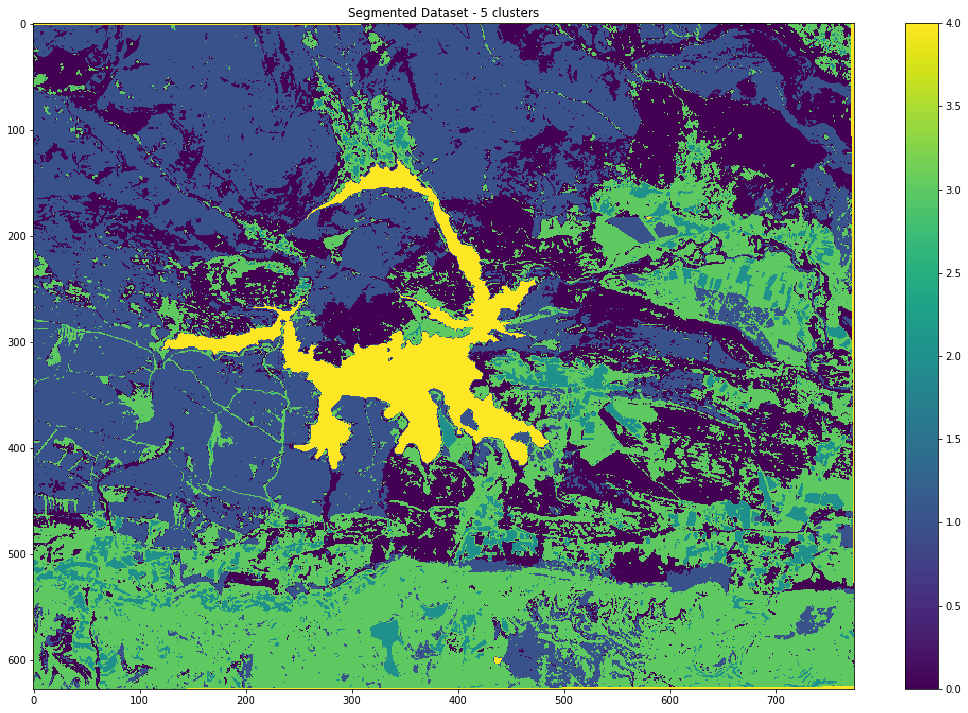

In [15]:
# Muestro los resultados del modelo de clasificacion

# Tomo las etiquetas del modelo, resultando un dataset de numeros de 0 a n clases
clusters = model.labels_

print("Formato matriz etiquetas resultantes kMeans: ", clusters.shape)

# Graba todos los valores correctamente, uno tras otro

# Muestro los resultados

plt.figure(figsize=(15,10))

plt.imshow(clusters.reshape(bands[0].shape)) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Segmented Dataset - 5 clusters")

plt.tight_layout()

plt.show()

Puedo representar una leyenda para ver la cantidad de pixeles clasificados en cada uno de los conjuntos, con la interpretación que parece más adecuada una vez visualizado el resultado anterior.

(array([121782.,      0., 170031.,      0.,      0.,  22030.,      0.,
        148751.,      0.,  23478.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

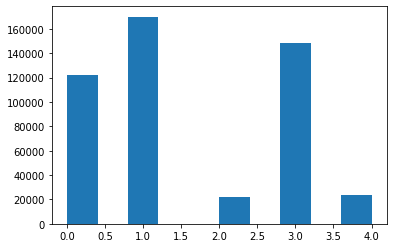

In [16]:
plt.hist(clusters)

# Al representar el histograma de clusters visualizo los patches (intervalos) en los que aparecen las clases de Kmeans

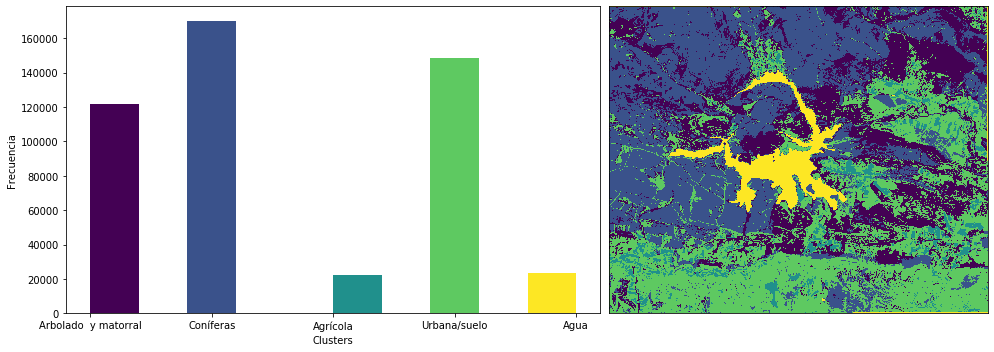

In [18]:
# Aunque el histograma se mantiene, puede cambiar la asignacion de clases y sus colores en cada ejecucion

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

n, bins, patches = ax1.hist(clusters)

# Fijo etiquetas
ax1.set_ylabel("Frecuencia")
ax1.set_xlabel("Clusters")


# Barras de colores para cada cluster
patches[0].set_facecolor("#440154") # morado
patches[2].set_facecolor("#3a528b") # cobalto
patches[5].set_facecolor("#20908c") # verde azulado
patches[7].set_facecolor("#5ec961") # verde claro
patches[9].set_facecolor("#fde724") # amarillo

# Deben ajustarse en cada ejecucion de k-means porque los patches no aparecen ordenados
ax1.set_xticks(range(5))
ax1.set_xticklabels(["Arbolado  y matorral", "Coníferas", "Agrícola", "Urbana/suelo", "Agua"])

ax2.imshow(clusters.reshape(bands[0].shape))

ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout(w_pad=-5) # Separacion entre graficos
plt.show()


A mayor número de clases, mayor es la influencia que tendrá el ruido que inevitablemente está contenido en ellas. La aplicación determina el mínimo número imprescidinble de clases.

Por otra parte, la clasificación en clusteres depende en gran medida de la zona a estudiar. Para una aplicacion específica de aguas se deberían enmascarar cualquier otra zona que no sea agua; y posteriormente aplicar el algoritmo. Así se le fuerza a buscar las diferencias más sutiles en ese subconjunto de datos que ya se han identificado como agua.

Esta clasificación no supervisada se puede usr para alimentar modelos supervisados como SVM o RN para obtener la división en clases sobre nuevos conjuntos, respetando las clases obtenidas -y supervisadas tras la inspección humana- con este modelo.

## Creacion de mascara con etiquetas reconocidas como agua

Uso una imagen con el embalse lleno a su máxima capacidad para determinar la máscara que permita posteriormente centrar otros estudios en el agua (p.e. nivel, calidad, etc).

Para crear la máscara pongo todas las clases salvo la de agua a cero. OJO: al tratarse de un aprendizaje no supervisado, K-Means no siempre asigna la misma etiqueta a cada clase. Así, en este ejemplo el agua aparece en la clase 4, pero en otra ejecución del algoritmo esto podría variar. 

En general, un aprendizaje no supervisado debe interpretarse. En este caso la interpretación consiste en la asignación de etiquetas de usos del suelo y agua en el histograma anterior, o en la asignación de valores para crear la máscara en el siguiente, en el que el agua toma el valor 4.

In [19]:
# Creo una mascara con el formato de la imagen a partir de la matriz de etiquetas

# Duplico el objeto resultante del etiquetado de la clasificacion para evitar corromperlo
import copy
mask = copy.copy(clusters) # Es una matriz float pero al copiar la hace int32

print('Formato máscara: ', mask.shape) # No tiene formato para guardarlo una vez creada la mascara
print('Tipo datos máscara: ', mask.dtype) # No tiene formato para guardarlo una vez creada la mascara


# Sustituyo por cero los valores asignados por k-means a las etiquetas que no corresponden al agua,
# y sustituo los valores de la etiqueta del agua por 1 (en el formato adecuado)
np.place(mask, mask==1, 0)
np.place(mask, mask==2, 0)
np.place(mask, mask==3, 0)
np.place(mask, mask==4, 255) # No es binaria, al copiar la paso a int32 debe ser 255

# Guardo la matriz con la mascara preparada para identificar el agua solamente, sin formato
np.savetxt('./Landsat8/np_mask_water.txt', mask, fmt='%i')

## Para representarlo lo doy formato

# Preparo la mascara para representar
mask_shp = mask.reshape(bands[0].shape)
print('Formato mascara en formato imagen: ', mask_shp.shape)


Formato máscara:  (486072,)
Tipo datos máscara:  int32
Formato mascara en formato imagen:  (628, 774)


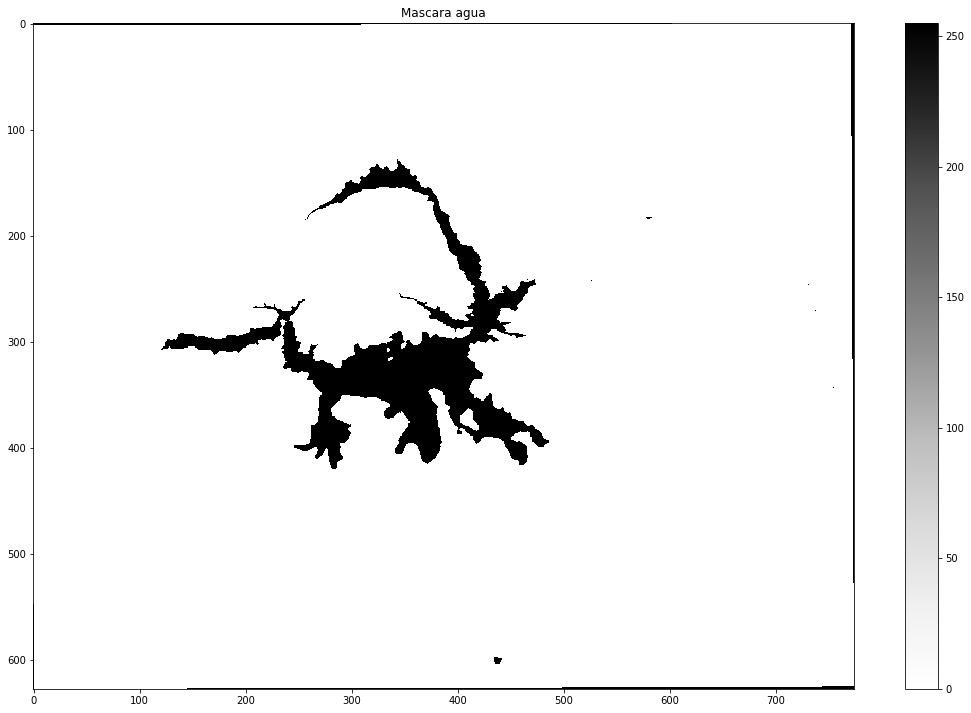

In [20]:
# Muestro los resultados del modelo de clasificacion

plt.figure(figsize=(15,10))

plt.imshow(mask_shp, cmap='Greys', interpolation='nearest') # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Mascara agua")

plt.tight_layout()


# Además de mostrar la imagen, la guardo como png
plt.show()

plt.imsave('./Landsat8/mascara.png', mask_shp)

In [21]:
# Creo un geotiff en coordenadas con la máscara

# Como el contenedor de rasterio solo cargo los datos matriciales debo cargar una banda, p.e. roja
imagePath = './Landsat8/'
escena_banda_roja = 'LC08_L1TP_201031_20160725_20170322_01_T1_B4.TIF'
band4 = rasterio.open(imagePath + escena_banda_roja)

xsize = mask_shp.shape[0]
ysize = mask_shp.shape[1]

m_trans = band4.transform

obj_mascara = rasterio.open('./Landsat8/mascara_geo.tiff', 'w', driver='GTiff',
                        height = mask_shp.shape[0], width = mask_shp.shape[1],
                        count = 1, # Reformateare despues al pasar los datos a write
                        dtype = str(mask_shp.dtype),
                        crs = band4.crs, # sistema de coordenadas
                        transform = m_trans)

# Escribo la matirz del objeto rasterio definido en el formato de la matriz banda4
obj_mascara.write(mask_shp.reshape(1, xsize, ysize), indexes = None) # Elimino indices para que no de error de formato

# Lo cierro
obj_mascara.close()

Perfil de la máscara:  {'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 774, 'height': 628, 'count': 1, 'crs': CRS.from_dict(init='epsg:32630'), 'transform': Affine(30.0, 0.0, 510585.0,
       0.0, -30.0, 4643325.0), 'tiled': False, 'interleave': 'band'}


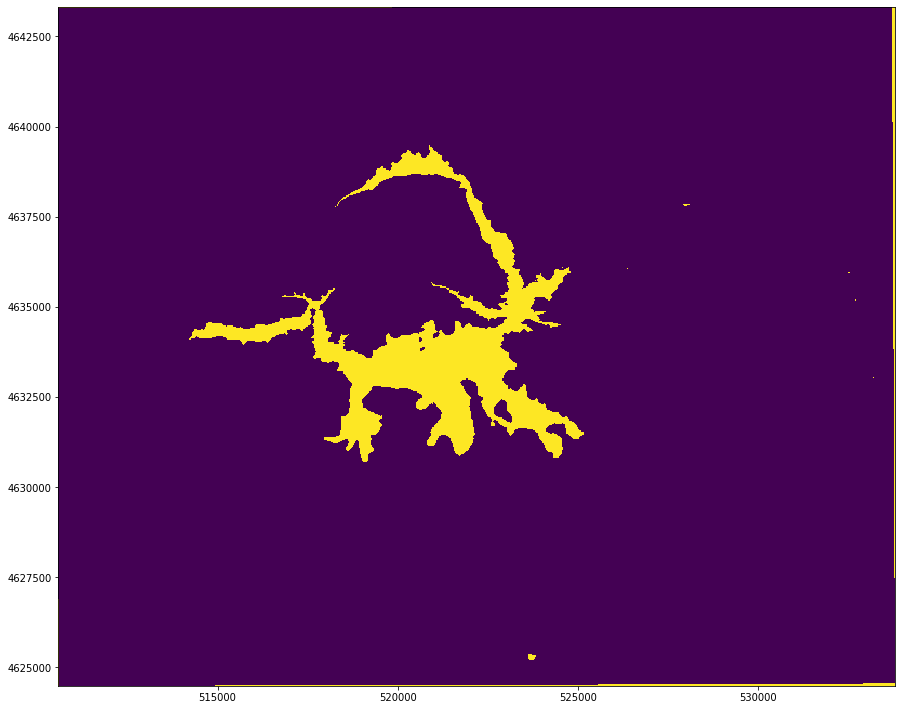

In [22]:
# Cargo imagen mascara para comprobar
mascara_geo = rasterio.open(imagePath + 'mascara_geo.tiff', masked=True) # Elimino valores de relleno

print("Perfil de la máscara: ", mascara_geo.profile)

# La muestro

plt.figure(figsize=(15,15))
plot.show(mascara_geo)

### Conversion de mascara geotiff a shp en coordenadas

Uso directamente GDAL con la instrucción polygonize para hacer la conversión.

Para funcionar en el entorno de programación de python es algo más complicado que llamándo a gdal_polygonize.py desde línea de comandos. Requiere un objeto de entrada "banda" de gdal, y debe definirse un objeto de salida con el driver del formato que deseamos generar, en este caso un shapefile de ESRI.

Además es imprescindible que todas las imagenes tengan la misma proyección y sistema de referencia, entre si y con el shp de corte, por lo que al convertir el geotiff a shp debemos conservarla.

In [23]:
# Cargo el geotiff a procesar como objeto GDAL (no rasterio)
sourceRaster = gdal.Open('./Landsat8/mascara_geo.tiff')
# Extraigo el sistema de proyección del geotiff
inSRS = sourceRaster.GetProjection()
print('Proyección del geotiff:\n', inSRS )

# Extraigo un objeto de banda GDAL
band = sourceRaster.GetRasterBand(1) # Este geotiff solo contiene una banda

# Defino el objeto de salida
outShapefile = "./Landsat8/mask_all"
driver = ogr.GetDriverByName("ESRI Shapefile")

# Controlo que no exista ya para evitar errores
if os.path.exists(outShapefile+".shp"):
    driver.DeleteDataSource(outShapefile+".shp")

# Uso la proyección del geotiff cargado con GDAL para definir la del shp
outSRS = osr.SpatialReference(wkt=inSRS)
    
# Creo el nuevo objeto con el sistema de referencia adecuado
outDatasource = driver.CreateDataSource(outShapefile+ ".shp")
outLayer = outDatasource.CreateLayer("polygonized", srs= outSRS)

# Conversion de archivo mascara_geo.tiff a shp
gdal.Polygonize( band, None, outLayer, -1, [], callback=None )
outDatasource.Destroy()

Proyección del geotiff:
 PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32630"]]


# Recorte SHP de imagenes de cada escena

Se usa una máscara shapefile filtrada manualmente a partir de la generada en el paso anterior. Para crearla se ha usado QGIS como editor gis (dijimos que todos los recursos empleados estarian disponibles libremente). Con él se han eliminado los elementos correspondientes a otros elementos que no se corresponden a la lámina de agua principal, del embalse.

La edición manual también es la forma más sencilla de asegurarse que la máscara filtrada y todas las imágenes descargadas tienen la misma proyección y sistema de referencia.

Usamos directamente GDAL, lo que no altera los valores de los pixeles en el raster y conserva mucha mas informacion de los datos de entrada.


In [24]:
# Defino variables de entorno para carga de imágenes y salida de recortes
inputPath = './Landsat8/'
outputPath = './Landsat8/recortes/'

# Defino archivo shp para el recorte
shp_cutter = inputPath+'wat_mask.shp'

In [25]:
# Defino nombres para cada archivo a cortar (si muchos puedo hacer lista)

# Si los ultimos cuatro caracteres del nombre del archivo en la carpeta son ".tif" los incorpora a la lista
bandList = [band for band in os.listdir(inputPath) if band[-4:]=='.TIF']

# Muestro la lista
bandList 

['LC08_L1TP_201031_20160725_20170322_01_T1_B1.TIF',
 'LC08_L1TP_201031_20160725_20170322_01_T1_B2.TIF',
 'LC08_L1TP_201031_20160725_20170322_01_T1_B3.TIF',
 'LC08_L1TP_201031_20160725_20170322_01_T1_B4.TIF',
 'LC08_L1TP_201031_20160725_20170322_01_T1_B5.TIF',
 'LC08_L1TP_201031_20160725_20170322_01_T1_B6.TIF',
 'LC08_L1TP_201031_20160725_20170322_01_T1_B7.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B1.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B2.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B3.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B4.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B5.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B6.TIF',
 'LC08_L1TP_201031_20170728_20170810_01_T1_B7.TIF',
 'LC08_L1TP_201031_20200704_20200708_01_T1_B1.TIF',
 'LC08_L1TP_201031_20200704_20200708_01_T1_B2.TIF',
 'LC08_L1TP_201031_20200704_20200708_01_T1_B3.TIF',
 'LC08_L1TP_201031_20200704_20200708_01_T1_B4.TIF',
 'LC08_L1TP_201031_20200704_20200708_01_T1_B5.TIF',
 'LC08_L1TP_

In [26]:
# Con gdal.Warp aplico el shp a las imágenes de la lista para recortarlas

for band in bandList:
    # Informo del archivo en proceso
    print(outputPath + 'r_shp_' + band)#) [:-4]+band[-4:])

    options = gdal.WarpOptions(cutlineDSName=shp_cutter,cropToCutline=True) # Opciones GDAL para el recorte dejando el interior
    outBand = gdal.Warp(srcDSOrSrcDSTab=inputPath + band, # Creo objeto recortado
                        destNameOrDestDS=outputPath + 'r_shp_' + band,#) [-4:], # archivo de salida
                        options=options) # aplica el resto de opciones
    
    outBand= None # Cierro salida para ahorrar memoria

print("\nProcesadas", len(bandList), "imágenes")

./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B1.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B2.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B3.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B4.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B5.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B6.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B7.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B1.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B2.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B3.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B4.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B5.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B6.TIF
./Landsat8/recortes/r_shp_LC08_L1TP_20

In [27]:
# Obtengo lista con nombres de escena, como valores unicos de la lista de bandas

bases=[] # Creo lista vacia para almacenar temporalmente los nombres

for band in bandList:
    bases.append(band[:40])
    
escenas = set(bases)

print("Escenas:\n", escenas) # Muestro valores unicos de las etiquetas


Escenas:
 {'LC08_L1TP_201031_20160725_20170322_01_T1', 'LC08_L1TP_201031_20170728_20170810_01_T1', 'LC08_L1TP_201031_20200704_20200708_01_T1', 'LC08_L1TP_201031_20200805_20200821_01_T1'}



Imagen:  r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_b2
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


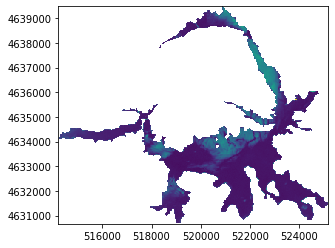


Imagen:  r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_b3
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


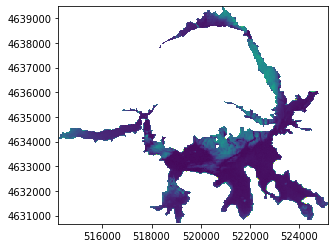


Imagen:  r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_b4
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


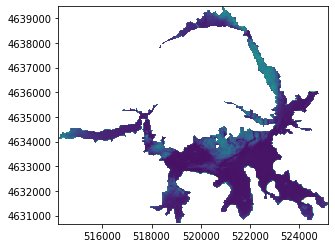


Imagen:  r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_b5
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


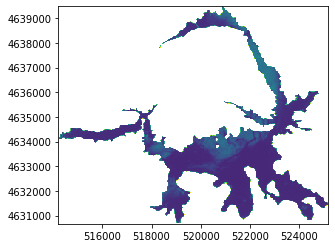


Imagen:  r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_b6
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


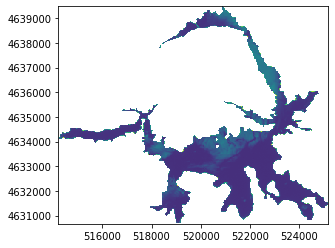


Imagen:  r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_b7
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


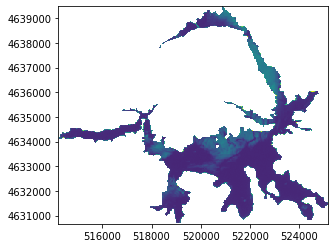


Imagen:  r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_b2
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


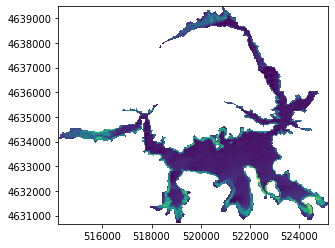


Imagen:  r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_b3
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


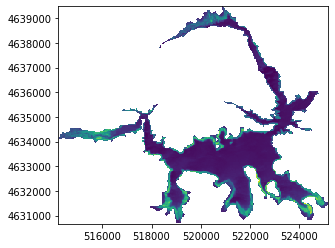


Imagen:  r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_b4
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


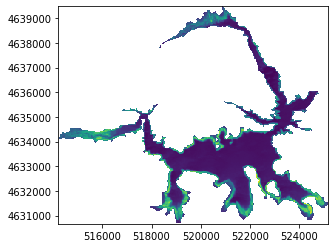


Imagen:  r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_b5
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


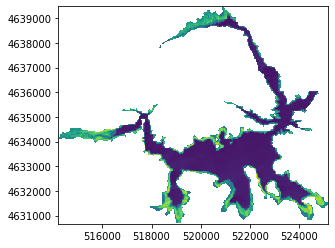


Imagen:  r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_b6
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


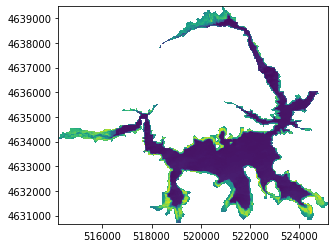


Imagen:  r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_b7
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


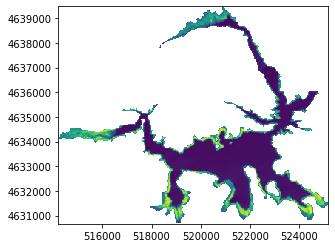


Imagen:  r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_b2
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


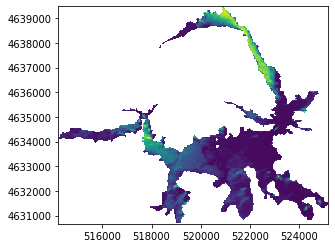


Imagen:  r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_b3
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


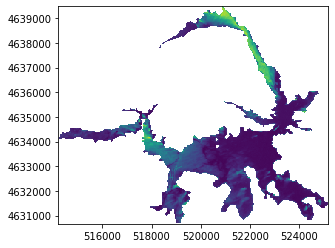


Imagen:  r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_b4
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


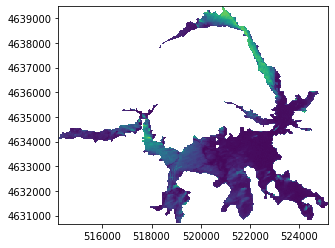


Imagen:  r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_b5
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


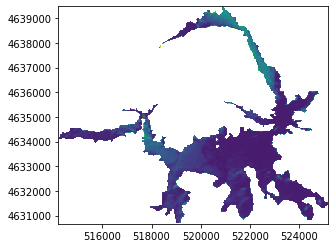


Imagen:  r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_b6
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


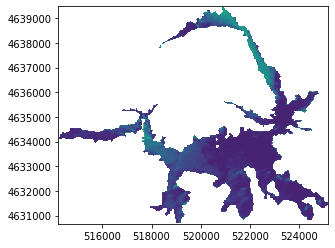


Imagen:  r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_b7
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


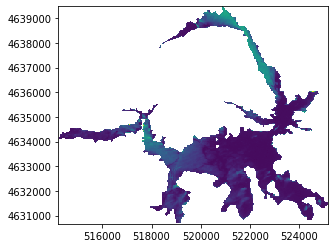


Imagen:  r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_b2
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


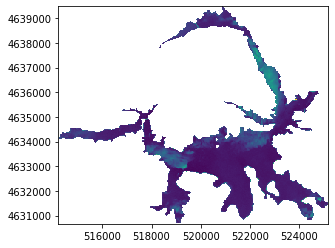


Imagen:  r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_b3
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


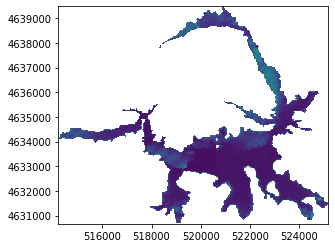


Imagen:  r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_b4
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


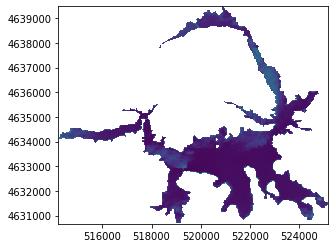


Imagen:  r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_b5
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


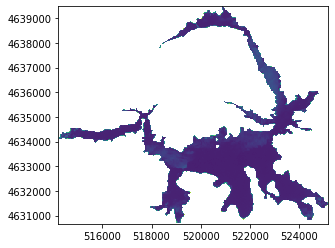


Imagen:  r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_b6
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


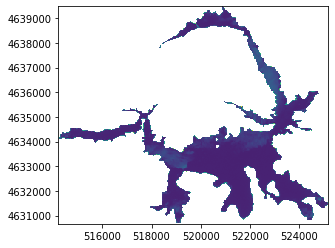


Imagen:  r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_b7
BoundingBox(left=514215.0, bottom=4630665.0, right=525165.0, top=4639485.0)


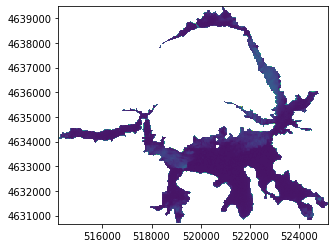

In [28]:
# Muestro imagenes
# Solo aquellas que tienen la misma resolucion y sin aerosoles (de la 2 a la 7)

for escena in escenas: # Para cada nombre de escena detectado
    for b in range (2, 8): # Incluye desde la 2 hasta la 7, y no la 8
        # cubo = rasterio.open(inputPath + escena + '_b' + str(b) +".TIF")
        cubo = rasterio.open(outputPath + 'r_shp_' + escena + '_b' + str(b) +".TIF")
        print("\nImagen: ", 'r_shp_' + escena + '_b' + str(b))
        print(cubo.bounds)
        plot.show(cubo)


## Clasificación de zonas con diferente calidad de agua

Simplemente con el recorte de la lámina de agua y la representación de las imágenes monobanda de cada una de las cuatro escenas del satélite ya apreciamos que aparecen diferentes zonas en cada una. Vamos a utilizar de nuevo la clasificación k-means para separarlas.

A continuación perfilaremos estas zonas usando un algoritmo de deteccion de bordes de Canny (1986) que detecta variaciones para determinar las firmas espectrales: suaviza la imagen con un filtro gausiano para eliminar ruido, se calculan los gradientes, se aplica supresión no máxima para eliminar bordes falsos, aplica un doble umbral para determinar posibles bordes y se confirman por histéresis para dejar solo bordes fuertes.

En esta ocasión, para simplificar el código debido al elevado número de imágenes recortadas (una para cada banda en cada escena), vamos a utilizar un formato de cubo de datos para su procesado, por lo que volveremos a cargar los datos. Las imágenes se repiten en las capas del cubo periódicamente, en funcion del número de bandas ópticas que utilizo.

In [29]:
# Preparo carga de bandas de las imagenes
imagePath = './Landsat8/recortes'

# Defino lista de bandas sensor optico sin pancromatica ni cirrus
N_OPTICS_BANDS = 7

# band1  - Aerosol costero, 0.43-0.45\u03BCm
# band2  - Azul, 0.45-0.51\u03BCm
# band3  - Verde, 0.53-0.59\u03BCm
# band4  - Rojo, 0.64-0.64\u03BCm
# band5  - Infrarrojo cercano (NIR), 0.85-0.88\u03BCm
# band6  - Infrarrojo de onda corta (SWIR) 1, 1.57-1.65\u03BCm
# band7  - Infrarrojo de onda corta (SWIR) 2, 2.11-2.29\u03BCm
# La letra r es un metacaracter de glob, debemos escaparlo en cada aparicion

# Para la primera imagen los archivos de sus bandas comienzan
DATA_FOLDER_1 = '.\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B[1-7].TIF'
DATA_FOLDER_2 = '.\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B[1-7].TIF'
DATA_FOLDER_3 = '.\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20200704_20200708_01_T1_B[1-7].TIF'
DATA_FOLDER_4 = '.\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20200805_20200821_01_T1_B[1-7].TIF'

bandsList = glob(DATA_FOLDER_1)
bandsList.extend(glob(DATA_FOLDER_2)) # no uso append porque añadiria lista completa, no sus elementos
bandsList.extend(glob(DATA_FOLDER_3)) # no uso append porque añadiria lista completa, no sus elementos
bandsList.extend(glob(DATA_FOLDER_4)) # no uso append porque añadiria lista completa, no sus elementos
print("\nLista de archivos de bandas a usar de la imagen: \n", bandsList)


Lista de archivos de bandas a usar de la imagen: 
 ['.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B1.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B2.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B3.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B4.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B5.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B6.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20160725_20170322_01_T1_B7.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B1.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B2.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B3.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20170728_20170810_01_T1_B4.TIF', '.\\Landsat8\\recortes\\r_shp_LC08_L1TP_201031_20170728_20170810_01

In [30]:
#Cargo todas las bandas en un contenedor múltiple de rasterio
bands = [rasterio.open(bandPath).read()[0] for bandPath in bandsList]


# Compruebo las bandas cargadas en el contenedor, un cubo multiespectral con las dos imagenes seguidas
len(bands)

28

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dimensiones RBG:  (294, 365, 3)


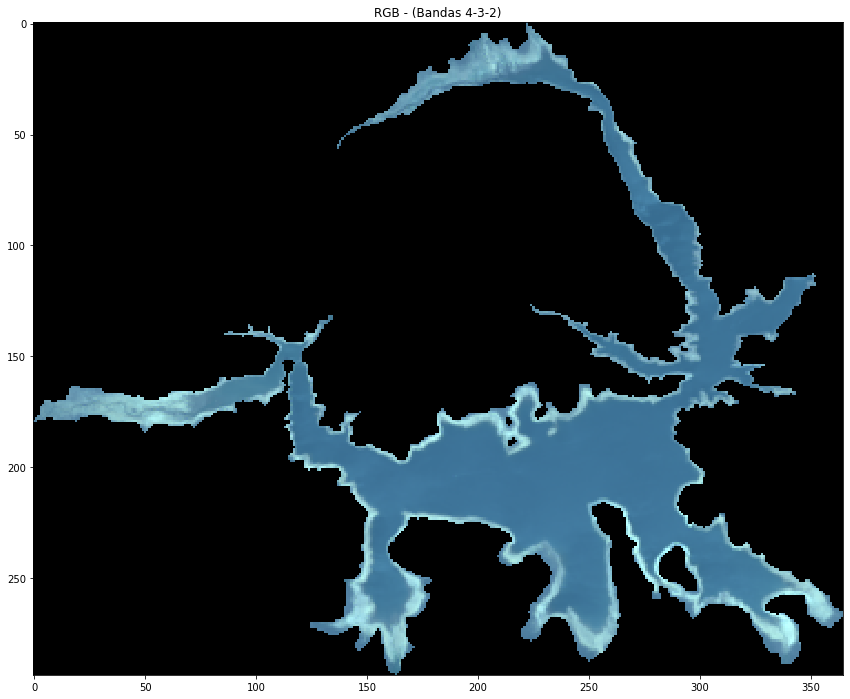

In [31]:
# Como comprobación de la carga del cubo de datos, muestro una combinacion 
# de las bandas visiblew en color simulado para la segunda escena (embalse bajo)


# Creo una composicion en color real mejorada, ajustando BIAS (sesgo global) y ganancia para cada banda
BIAS = 1
GAIN = [0.8, 1.1, 1.1]

# Extraigo bandas para representacion RGB y reescalo con bias y ganancia
r = (bands[3+N_OPTICS_BANDS] - bands[3+N_OPTICS_BANDS].min()) / (bands[3+N_OPTICS_BANDS].max()-bands[3+N_OPTICS_BANDS].min()) * GAIN[0] * BIAS
g = (bands[2+N_OPTICS_BANDS] - bands[2+N_OPTICS_BANDS].min()) / (bands[2+N_OPTICS_BANDS].max()-bands[2+N_OPTICS_BANDS].min()) * GAIN[1] * BIAS
b = (bands[1+N_OPTICS_BANDS] - bands[1+N_OPTICS_BANDS].min()) / (bands[1+N_OPTICS_BANDS].max()-bands[1+N_OPTICS_BANDS].min()) * GAIN[2] * BIAS

# Creo arreglo numpy con las bandas RGB procesadas
rgbImage = np.zeros((bands[1+N_OPTICS_BANDS].shape[0], bands[1+N_OPTICS_BANDS].shape[1], 3))
rgbImage[:,:,0] = r
rgbImage[:,:,1] = g
rgbImage[:,:,2] = b
print("Dimensiones RBG: ", rgbImage.shape)

# Muestro la composicion
plt.figure(figsize=(16,12))
plt.imshow(rgbImage)
plt.title("RGB - (Bandas 4-3-2)")

plt.show()

### Clasificacion del agua en clusters K-Means

Usamos de nuevo el algoritmo k-means no supervisado, por lo que será crucial la interpretación posterior.

Dado que el conjunto de datos está en formato multidimensional (n bandas de x * y píxeles), lo reformateamos para ponerlo en formato plano ordenado, con una fila para cada pixel de la imagen, y una columna para cada banda.

Pruebo diferentes modelos, para las imagenes por separado (1, 2, 3 y 4) y conjuntas (u), para ver como actuan en las condiciones temporales de cada una, y en general para las diversas situaciones.


In [32]:
# Aplano los datos de cada banda en una lista, separada para cada imagen
vectors1 = [band.reshape(bands[1].shape[0]*bands[1].shape[1], 1) for band in bands[0:7]]
print("Longitud lista vectores imagen 1: ", len(vectors1))

vectors2 = [band.reshape(bands[1].shape[0]*bands[1].shape[1], 1) for band in bands[7:14]]
print("Longitud lista vectores imagen 2: ", len(vectors2))

vectors3 = [band.reshape(bands[1].shape[0]*bands[1].shape[1], 1) for band in bands[14:21]]
print("Longitud lista vectores imagen 3: ", len(vectors3))

vectors4 = [band.reshape(bands[1].shape[0]*bands[1].shape[1], 1) for band in bands[21:28]]
print("Longitud lista vectores imagen 4: ", len(vectors4))


# Reformateo los datos de la lista en una matriz para cada imagen
reshapedDataset1 = np.array(vectors1).reshape(N_OPTICS_BANDS, bands[1].shape[0]*bands[1].shape[1]).transpose()
print("\nFormato dataset aplanado imagen 1: ", reshapedDataset1.shape)

reshapedDataset2 = np.array(vectors2).reshape(N_OPTICS_BANDS, bands[1].shape[0]*bands[1].shape[1]).transpose()
print("Formato dataset aplanado imagen 2: ", reshapedDataset2.shape)

reshapedDataset3 = np.array(vectors3).reshape(N_OPTICS_BANDS, bands[1].shape[0]*bands[1].shape[1]).transpose()
print("Formato dataset aplanado imagen 3: ", reshapedDataset3.shape)

reshapedDataset4 = np.array(vectors4).reshape(N_OPTICS_BANDS, bands[1].shape[0]*bands[1].shape[1]).transpose()
print("Formato dataset aplanado imagen 4: ", reshapedDataset4.shape)

Longitud lista vectores imagen 1:  7
Longitud lista vectores imagen 2:  7
Longitud lista vectores imagen 3:  7
Longitud lista vectores imagen 4:  7

Formato dataset aplanado imagen 1:  (107310, 7)
Formato dataset aplanado imagen 2:  (107310, 7)
Formato dataset aplanado imagen 3:  (107310, 7)
Formato dataset aplanado imagen 4:  (107310, 7)


#### Análisis de la primera imagen, embalse lleno

Uso 5 clases para la clasificación, porque en cualquier caso, dos de ellas se identificarán con los valores enmascarados y con los valores de borde. Esto deja tres clases para identificar las zonas con firmas espectrales características para las condiciones en las que se registraron los datos.

In [33]:
# Defino modelo conjunto que entreno con los dos dataset aplanados juntos
model_1 = KMeans(5)

# Lo entreno con los datos de cada dataset aplanado
model_1.fit(reshapedDataset1)


# Ejecuto el modelo con autoajustes. Fijo random_state en vez de dejar None para reproducir resultados
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, 
       random_state=None, tol=0.0001, verbose=0)

# Informo de los centroides que ha encontrado para los datos
centroids_1 = model_1.cluster_centers_

print("Iteraciones realizadas: ", model_1.n_iter_)

print("\nGrupos de centroides (clases): ", len(centroids_1))
print("Formato centroides: ", centroids_1.shape)
print("Centroides (clases) con 7 componentes (bandas):\n", centroids_1)


Iteraciones realizadas:  7

Grupos de centroides (clases):  5
Formato centroides:  (5, 7)
Centroides (clases) con 7 componentes (bandas):
 [[-3.72301656e-09  2.76349965e-09  2.17437446e-09  9.88620741e-10
   1.96473593e-09  4.18367563e-11  4.58157956e-10]
 [ 9.21807273e+03  8.30063021e+03  7.38472252e+03  6.62059021e+03
   6.09935804e+03  5.68412476e+03  5.52728000e+03]
 [ 9.63566074e+03  8.76231425e+03  7.88954755e+03  7.19370879e+03
   6.81801645e+03  6.35952813e+03  6.07945837e+03]
 [ 8.93470592e+03  7.98126841e+03  6.95727329e+03  6.13893042e+03
   5.49705292e+03  5.15738085e+03  5.10760737e+03]
 [ 9.33549660e+03  8.48962358e+03  7.92200000e+03  7.35232426e+03
   8.66933107e+03  7.53237415e+03  6.66112472e+03]]


Etiquetas:  {0, 1, 2, 3, 4}


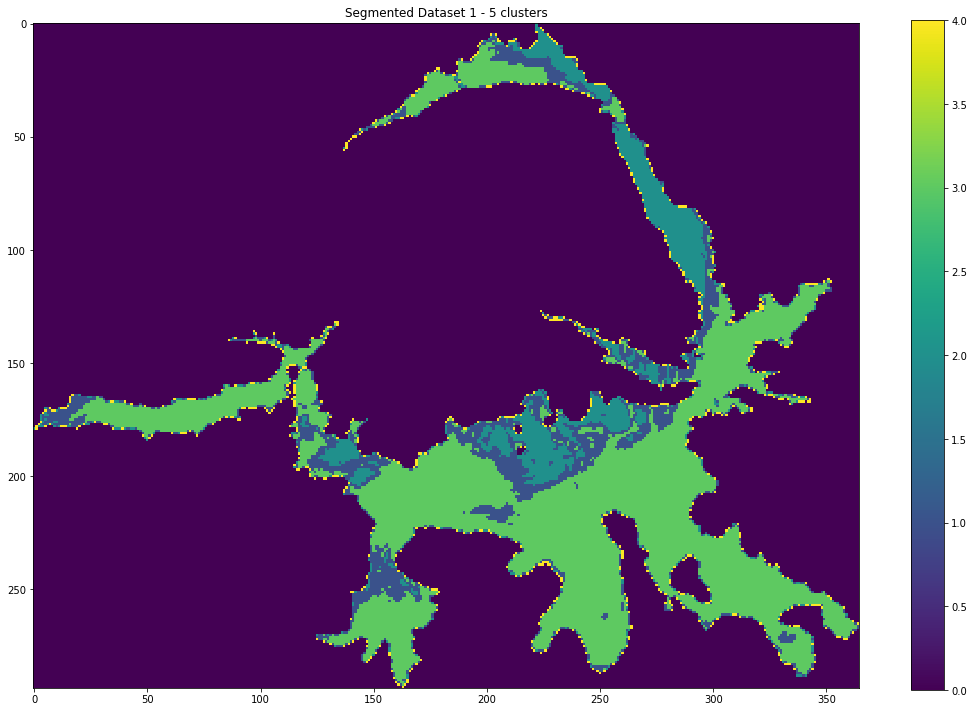

In [34]:
# Muestro los resultados del modelo de clasificacion

# Tomo las etiquetas del modelo, resultando un dataset de numeros de 0 a n clases
clusters_1 = model_1.labels_

print("Etiquetas: ", set(clusters_1)) # Muestro valores unicos de las etiquetas

plt.figure(figsize=(15,10))

plt.imshow(clusters_1.reshape(bands[0].shape)) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Segmented Dataset 1 - 5 clusters")

plt.tight_layout()

plt.show()

# Las clases se asignan arbitrariamente y en cada ejecucion los colores pueden cambiar

Con este analisis K-Means identifica zonas con probablemente elevada turbidez, en la vertical del brazo ascendene del embalse, y en su zona central.

#### Análisis de la segunda imagen, embalse bajo

In [35]:
# Defino modelo conjunto que entreno con los dos dataset aplanados juntos
model_2 = KMeans(5)

# Lo entreno con los datos de cada dataset aplanado
model_2.fit(reshapedDataset2)


# Ejecuto el modelo con autoajustes. Fijo random_state en vez de dejar None para reproducir resultados
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, 
       random_state=None, tol=0.0001, verbose=0)

# Informo de los centroides que ha encontrado para los datos
centroids_2 = model_2.cluster_centers_


print("Iteraciones realizadas: ", model_2.n_iter_)

print("\nGrupos de centroides (clases): ", len(centroids_2))
print("Formato centroides: ", centroids_2.shape)
print("Centroides (clases) con 7 componentes (bandas):\n", centroids_2)

Iteraciones realizadas:  6

Grupos de centroides (clases):  5
Formato centroides:  (5, 7)
Centroides (clases) con 7 componentes (bandas):
 [[ 9.78997399e+03  9.00984909e+03  8.35355318e+03  7.37440282e+03
   6.57438195e+03  6.14541645e+03  5.94371196e+03]
 [-2.04340722e-09  1.32399691e-09  2.08069650e-09 -2.38787834e-09
   2.39924702e-09  2.88173396e-09  1.62390279e-09]
 [ 1.13492063e+04  1.10531242e+04  1.19012133e+04  1.34162511e+04
   1.83655166e+04  2.12463595e+04  1.79736366e+04]
 [ 1.27298364e+04  1.28663494e+04  1.48769797e+04  1.76091371e+04
   2.29020823e+04  2.68295971e+04  2.38243361e+04]
 [ 1.05321945e+04  9.99091937e+03  1.01618628e+04  1.07521205e+04
   1.40132032e+04  1.53924742e+04  1.27407157e+04]]


Etiquetas:  {0, 1, 2, 3, 4}


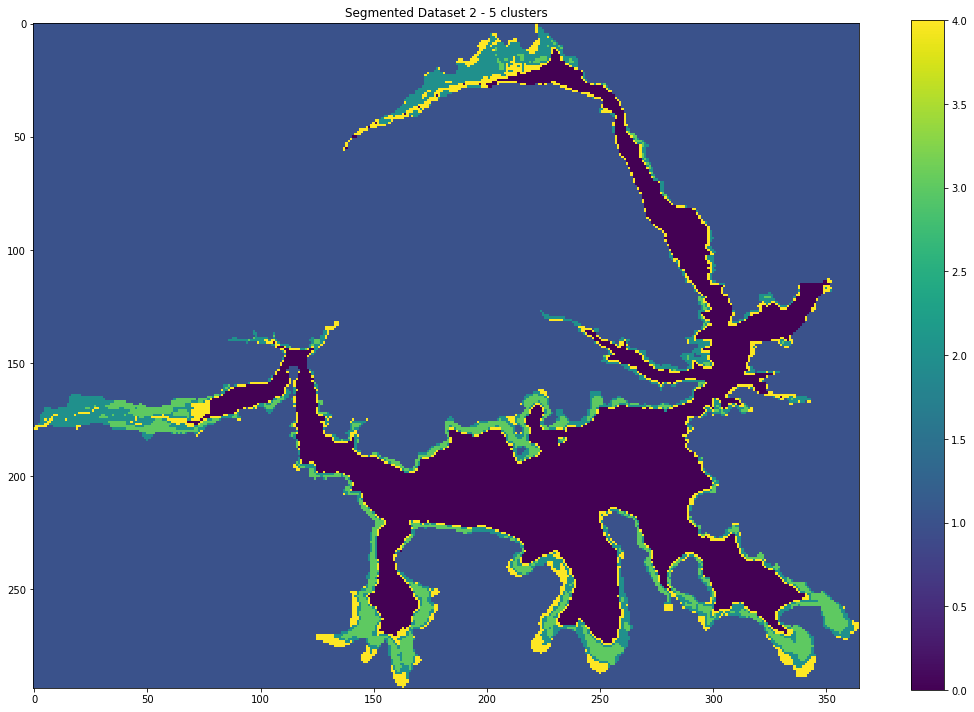

In [36]:
# Muestro los resultados del modelo de clasificacion

# Tomo las etiquetas del modelo, resultando un dataset de numeros de 0 a n clases
clusters_2 = model_2.labels_

print("Etiquetas: ", set(clusters_2)) # Muestro valores unicos de las etiquetas

plt.figure(figsize=(15,10))

plt.imshow(clusters_2.reshape(bands[0].shape)) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Segmented Dataset 2 - 5 clusters")

plt.tight_layout()

plt.show()

# Las clases se asignan arbitrariamente y en cada ejecucion los colores pueden cambiar


Con este análisis, K-Means identifica claramente las zonas de ribera que han quedado al aire tras el descenso de la lámina de agua por la sequía, así como su diferente grado de humedad. La diferencia en estas zonas es tan acusada, que al limitarse el número de clases, el algoritmo no obtiene más discriminaciones en el cojunto de la lámina de agua.

#### Análisis de la tercera imagen, embalse lleno

In [37]:
# Defino modelo conjunto que entreno con los dos dataset aplanados juntos
model_3 = KMeans(5)

# Lo entreno con los datos de cada dataset aplanado
model_3.fit(reshapedDataset3)


# Ejecuto el modelo con autoajustes. Fijo random_state en vez de dejar None para reproducir resultados
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, 
       random_state=None, tol=0.0001, verbose=0)

# Informo de los centroides que ha encontrado para los datos
centroids_3 = model_3.cluster_centers_


print("Iteraciones realizadas: ", model_3.n_iter_)

print("\nGrupos de centroides (clases): ", len(centroids_3))
print("Formato centroides: ", centroids_3.shape)
print("Centroides (clases) con 7 componentes (bandas):\n", centroids_3)


Iteraciones realizadas:  5

Grupos de centroides (clases):  5
Formato centroides:  (5, 7)
Centroides (clases) con 7 componentes (bandas):
 [[-4.02974365e-09  3.63911568e-09 -1.39539225e-09 -2.46609488e-09
  -1.10139808e-09 -1.41108103e-09 -2.67391442e-10]
 [ 9.33366645e+03  8.36944624e+03  7.31859462e+03  6.57004796e+03
   6.17343849e+03  5.73149677e+03  5.56585118e+03]
 [ 9.03031714e+03  8.03306443e+03  6.90863227e+03  6.11679024e+03
   5.58519223e+03  5.19991490e+03  5.13747446e+03]
 [ 1.03932136e+04  9.55360924e+03  8.64745308e+03  8.04012185e+03
   7.90488095e+03  7.33320658e+03  6.89527031e+03]
 [ 9.72785399e+03  8.80751560e+03  7.83154463e+03  7.13266681e+03
   6.96603726e+03  6.42498917e+03  6.11367114e+03]]


Etiquetas:  {0, 1, 2, 3, 4}


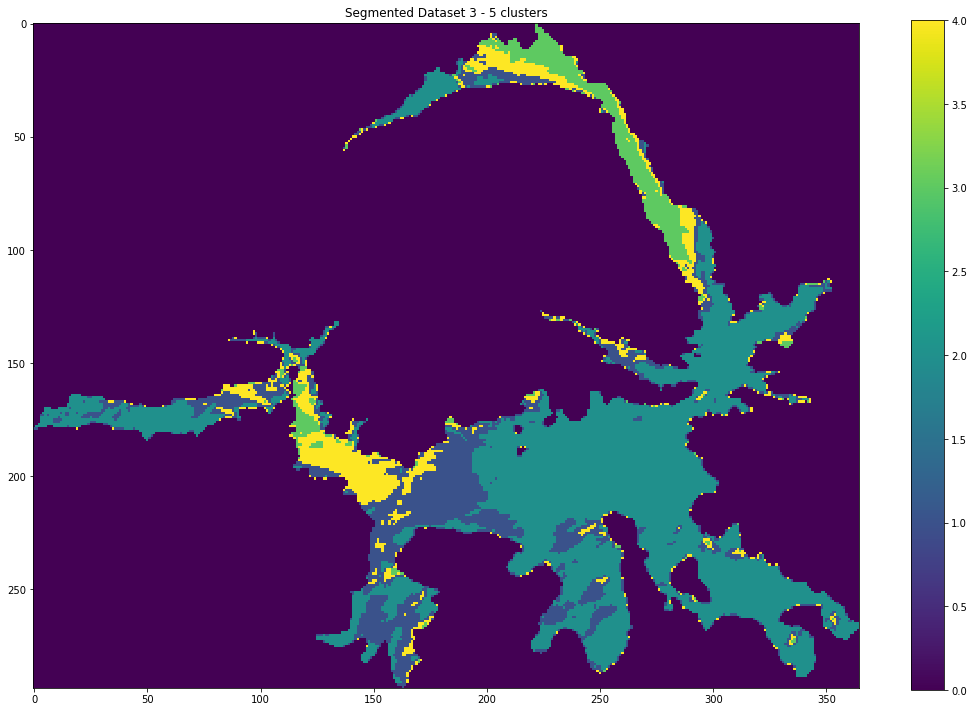

In [38]:
# Muestro los resultados del modelo de clasificacion

# Tomo las etiquetas del modelo, resultando un dataset de numeros de 0 a n clases
clusters_3 = model_3.labels_

print("Etiquetas: ", set(clusters_3)) # Muestro valores unicos de las etiquetas

plt.figure(figsize=(15,10))

plt.imshow(clusters_3.reshape(bands[0].shape)) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Segmented Dataset 3 - 5 clusters")

plt.tight_layout()

plt.show()

# Las clases se asignan arbitrariamente y en cada ejecucion los colores pueden cambiar


Este análisis resulta mas complejo de interpretar, con quizá la turbidez localizada en la zona media de los ramales de entrada y la mitad del embalse, y otras condiciones en el resto.

#### Análisis de la cuarta imagen, embalse lleno

In [39]:
# Defino modelo conjunto que entreno con los dos dataset aplanados juntos
model_4 = KMeans(5)

# Lo entreno con los datos de cada dataset aplanado
model_4.fit(reshapedDataset4)


# Ejecuto el modelo con autoajustes. Fijo random_state en vez de dejar None para reproducir resultados
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, 
       random_state=None, tol=0.0001, verbose=0)

# Informo de los centroides que ha encontrado para los datos
centroids_4 = model_4.cluster_centers_


print("Iteraciones realizadas: ", model_4.n_iter_)

print("\nGrupos de centroides (clases): ", len(centroids_4))
print("Formato centroides: ", centroids_4.shape)
print("Centroides (clases) con 7 componentes (bandas):\n", centroids_4)


Iteraciones realizadas:  24

Grupos de centroides (clases):  5
Formato centroides:  (5, 7)
Centroides (clases) con 7 componentes (bandas):
 [[ 1.76532922e-09 -8.63792593e-10  1.35264600e-09  2.32353159e-09
  -2.02044248e-09  1.74350134e-09  1.22713573e-09]
 [ 8.93844987e+03  8.00002596e+03  6.94464948e+03  6.13246413e+03
   5.57234954e+03  5.16191963e+03  5.10030534e+03]
 [ 9.33540365e+03  8.48048177e+03  7.68236146e+03  6.93978594e+03
   6.83003333e+03  6.21136667e+03  5.88596563e+03]
 [ 9.13563349e+03  8.23585238e+03  7.31076866e+03  6.51342893e+03
   5.99989709e+03  5.53587178e+03  5.40058709e+03]
 [ 9.26343081e+03  8.43219013e+03  7.86584236e+03  7.28720337e+03
   8.89606859e+03  7.62476173e+03  6.66549819e+03]]


Etiquetas:  {0, 1, 2, 3, 4}


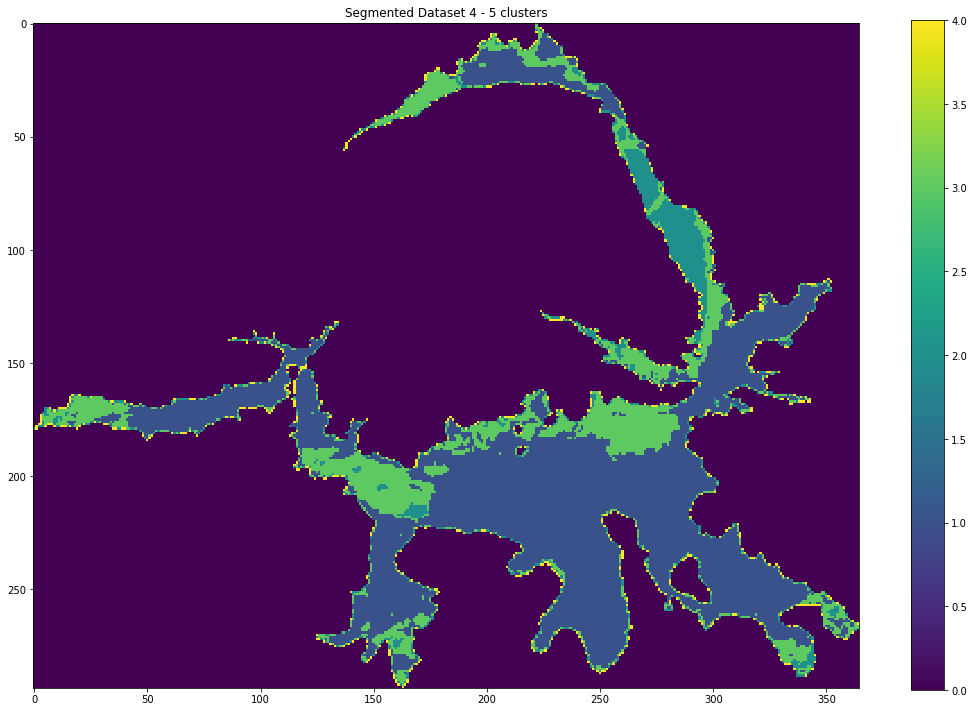

In [40]:
# Muestro los resultados del modelo de clasificacion

# Tomo las etiquetas del modelo, resultando un dataset de numeros de 0 a n clases
clusters_4 = model_4.labels_

print("Etiquetas: ", set(clusters_4)) # Muestro valores unicos de las etiquetas

plt.figure(figsize=(15,10))

plt.imshow(clusters_4.reshape(bands[0].shape)) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Segmented Dataset 4 - 5 clusters")

plt.tight_layout()

plt.show()

# Las clases se asignan arbitrariamente y en cada ejecucion los colores pueden cambiar


Del análisis parece diferenciarse entre zonas con mayor turbidez en las cabeceras con aporte por la izquierda, en el brazo descendente y en zonas con probablemente mayor escorrentia.

#### Analisis conjunto, todas las imagenes a la vez

Requiere un mayor número de clases, para reflejar todos los fenómenos posibles que pueden predominar en cada zona del embalse: nivel de lámina de agua, aportes, escorrentía de másgenes, eutorofización....

El algoritmo de clasificación solo divide las zonas, no indica los datos que las provocan y mucho menos el fenómeno físico-químico subyacente.

In [41]:
# Aplano los datos de cada banda en una lista
vectors_u = [band.reshape(bands[1].shape[0]*bands[1].shape[1], 1) for band in bands]
print("Longitud lista vectores conjunto completo ", len(vectors_u))

# Reformateo los datos de la lista en una matriz para cada imagen
reshapedDataset_u = np.array(vectors_u).reshape(4*N_OPTICS_BANDS, bands[1].shape[0]*bands[1].shape[1]).transpose()
print("\nFormato dataset aplanado conjunto completo: ", reshapedDataset_u.shape)

Longitud lista vectores conjunto completo  28

Formato dataset aplanado conjunto completo:  (107310, 28)


In [42]:
# Defino modelo conjunto que entreno con los dos dataset aplanados juntos
model_u = KMeans(10)

# Lo entreno con los datos de cada dataset aplanado
model_u.fit(reshapedDataset_u)


# Ejecuto el modelo con autoajustes. Fijo random_state en vez de dejar None para reproducir resultados
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10,
       random_state=None, tol=0.0001, verbose=0)

# Informo de los centroides que ha encontrado para los datos
centroids_u = model_u.cluster_centers_


print("Iteraciones realizadas: ", model_u.n_iter_)

print("\nGrupos de centroides (clases): ", len(centroids_u))
print("Formato centroides: ", centroids_u.shape)
print("Centroides (clases) con 7 componentes (bandas):\n", centroids_u)


Iteraciones realizadas:  64

Grupos de centroides (clases):  10
Formato centroides:  (10, 28)
Centroides (clases) con 7 componentes (bandas):
 [[-3.72301656e-09  2.76349965e-09  2.17437446e-09  9.88620741e-10
   1.96473593e-09  4.18367563e-11  4.58157956e-10 -2.04340722e-09
   1.32399691e-09  2.08069650e-09 -2.38787834e-09  2.39924702e-09
   2.88173396e-09  1.62390279e-09 -4.02974365e-09  3.63911568e-09
  -1.39539225e-09 -2.46609488e-09 -1.10139808e-09 -1.41108103e-09
  -2.67391442e-10  1.76532922e-09 -8.63792593e-10  1.35264600e-09
   2.32353159e-09 -2.02044248e-09  1.74350134e-09  1.22713573e-09]
 [ 9.10378404e+03  8.19213298e+03  7.35032926e+03  6.59671117e+03
   6.05220798e+03  5.62824574e+03  5.45962021e+03  1.14534378e+04
   1.11894702e+04  1.21317840e+04  1.37579239e+04  1.86842580e+04
   2.15337160e+04  1.83363670e+04  9.26762606e+03  8.30498777e+03
   7.28971011e+03  6.51640479e+03  6.08522872e+03  5.64399521e+03
   5.49137287e+03  9.03763351e+03  8.14751809e+03  7.31329362e+0

Etiquetas:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


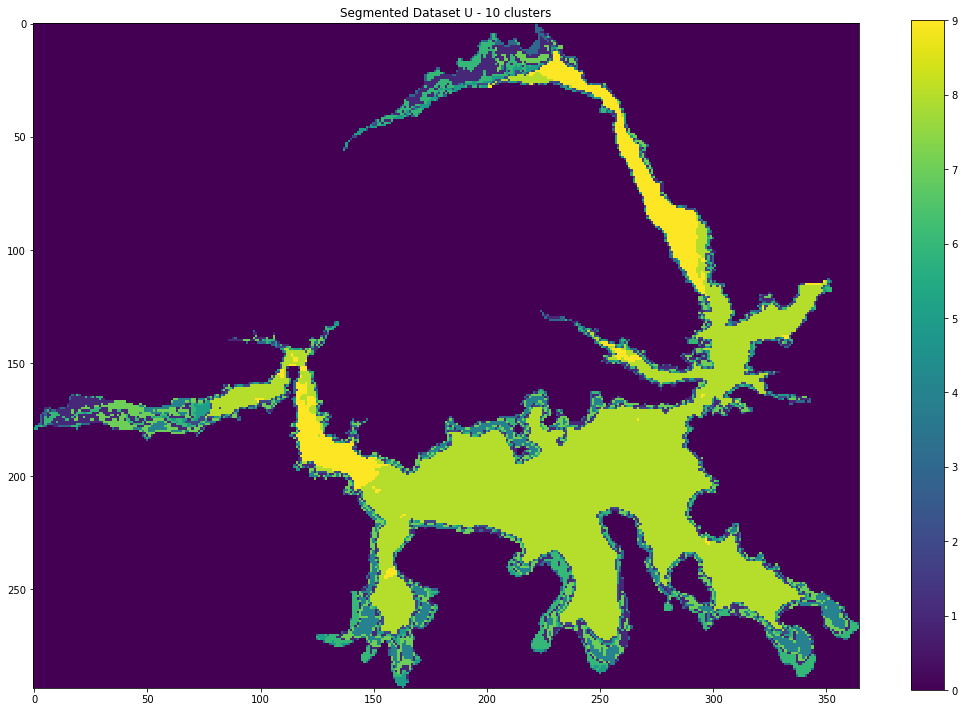

In [43]:
# Muestro los resultados del modelo de clasificacion

# Tomo las etiquetas del modelo, resultando un dataset de numeros de 0 a n clases
clusters_u = model_u.labels_

print("Etiquetas: ", set(clusters_u)) # Muestro valores unicos de las etiquetas

plt.figure(figsize=(15,10))

plt.imshow(clusters_u.reshape(bands[0].shape)) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Segmented Dataset U - 10 clusters")

plt.tight_layout()

plt.show()

# Las clases se asignan arbitrariamente y en cada ejecucion los colores pueden cambiar


## Reconocimiento con algoritmo de Canny

La técnica de Canny en una clave tradicional se divide en las siguientes fases:
1.	Reducción de ruido por convolución con un filtro gaussiano;
2.	Cálculo del gradiente de la imagen en las cuatro direcciones (horizontal, vertical y 2 oblicuas);
3.	Extracción de máximos de gradiente local;
4.	Umbral con hiteresis para extracción de bordes.

### Aplicacion al primer dataset

Comencezamos convirtiendo el resultado de la agrupación en clústeres en imágenes y luego reduciendo su ruido a través de un filtro de caja con kernel gaussiano de 15x15 (siempre valores positivos e impares) y desviacion estandar 0 en ambas direcciones. Este filtro toma todos los puntos los vecinos de cada pixel y toma el promedio ponderado gausiano. Puede difuminar un poco los bordes.

Como opción inicial, si quisieramos resaltar los bordes podriamos usar un filtro bilateral (línea comentada).

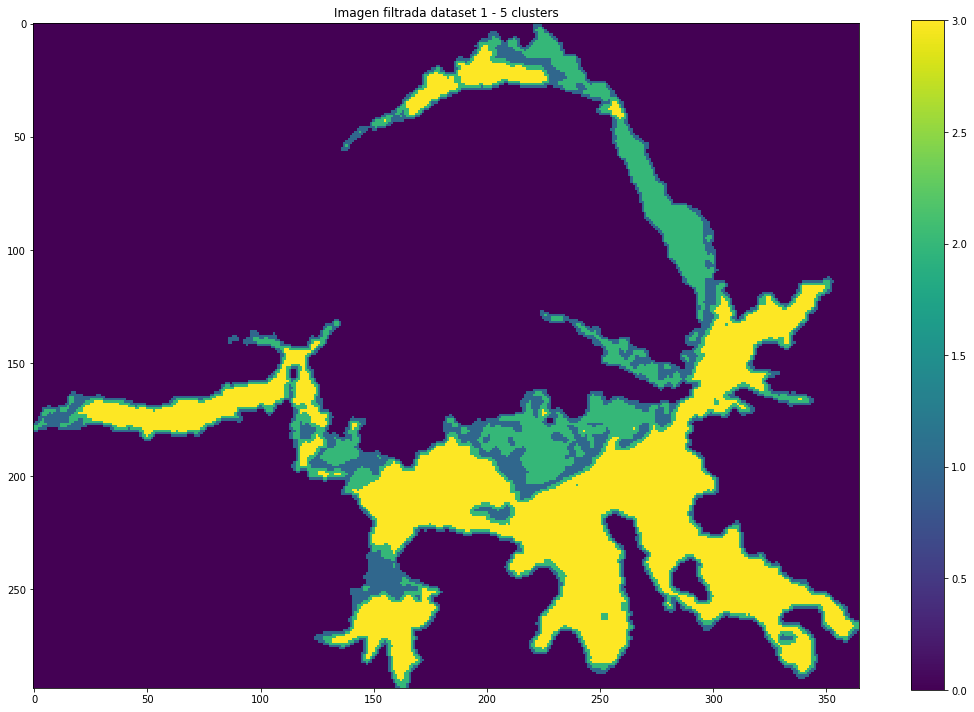

In [44]:
## Filtrado sobre el dataset de union y el modelo de clasificacion conjunto para la primera imagen

# Convertimos el cluster de resultados a formato imagen uint8 (por defecto es uint32, ahorra memoria)
cluster_1_IMG = clusters_1.reshape(bands[0].shape).astype('uint8')

# Filtro gausiano de 15x14
blurred_IMG_1 = cv.GaussianBlur(cluster_1_IMG, (5,5), 0)

# blurred_IMG_u = cv.bilateralFilter(cluster_u_IMG, 9, 75, 75) para resaltar mas los contornos
                                  
plt.figure(figsize=(15,10))

plt.imshow(blurred_IMG_1) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Imagen filtrada dataset 1 - 5 clusters")

plt.tight_layout()

plt.show()


Una vez aplicado el filtro de reduccion de ruido, aplicamos el algoritmo de Canny.

En una sola instrucción, calcula los gradientes en la direccion horizontal y vertical para cada punto (kernel de Sobel). El gradiente es máximo en la dirección perpendicular a un borde.

Localizado el gradiente y su dirección a continuación elimina los pixeles que no cumplen la condicion de borde (gradiente maximo local, siguiendo una dirección que será perpendicular al degradado del gradiente).

Por último, aplica un valor umbral de arista (filtro de mínimo y máximo) para clasificar los bordes, descartando los que están por debajo o por encima del umbral. Basta con que un punto esté clasificado como borde y supere el límite máximo del umbral (borde seguro), para que todos los conectados con él sean considerados como una arista.

Para usar la funcion en cv, pasamos el nombre de la imagen de entrada (en formato numpy), y los valores mínimo y máximo del umbral. A continuación el tamaño de apertura o del kernel de Sobel usado para buscar los degradados en la imagen, por defecto 3.


In [45]:
# El resultado simplifica (desenfoca) la imagen resultante de la clasificacion
# Ejecutamos Canny con la libreria cv

rawEdge_1 = cv.Canny(blurred_IMG_1, 2, 5, 3).astype("float").reshape(cluster_1_IMG.shape)

print("Formato imagen procesada con Canny: ", rawEdge_1.shape)


Formato imagen procesada con Canny:  (294, 365)


In [46]:
# En una sola línea de código obtenemos el degradado,extrajimos los máximos locales y luego aplicamos el umbral con hiteresis para cada captura.

edges_1 = []
for edge in rawEdge_1:
    edge[edge == 0] = np.nan
    edges_1.append(edge)


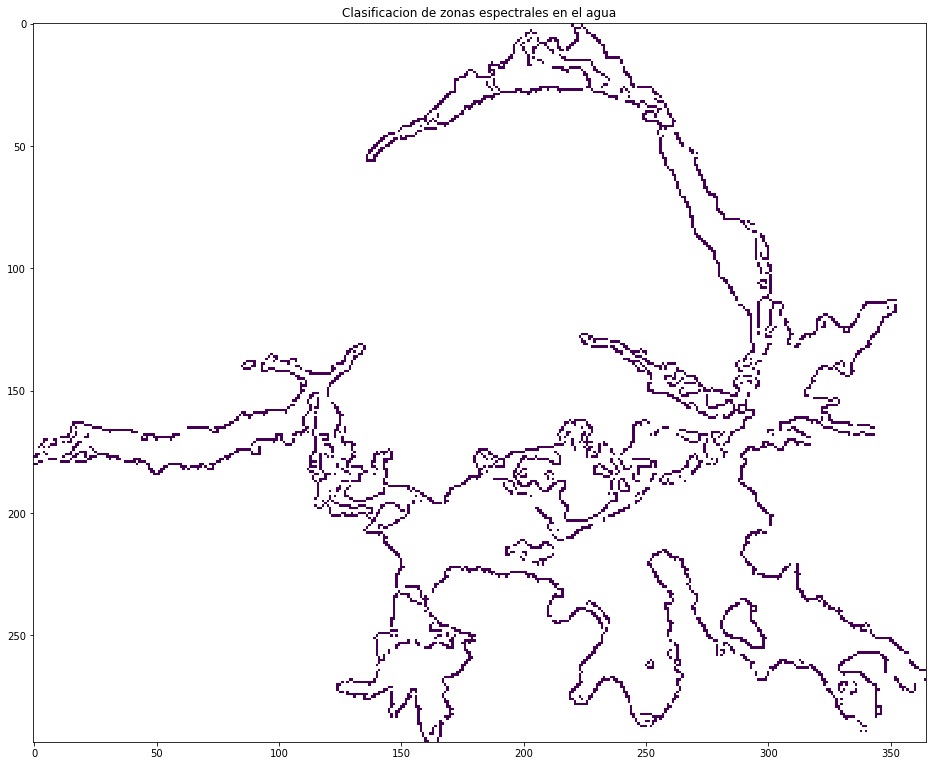

In [47]:
plt.figure(figsize=(16,30))

plt.imshow(edges_1)

plt.title('Clasificacion de zonas espectrales en el agua')

plt.show()


### Aplicacion al segundo dataset

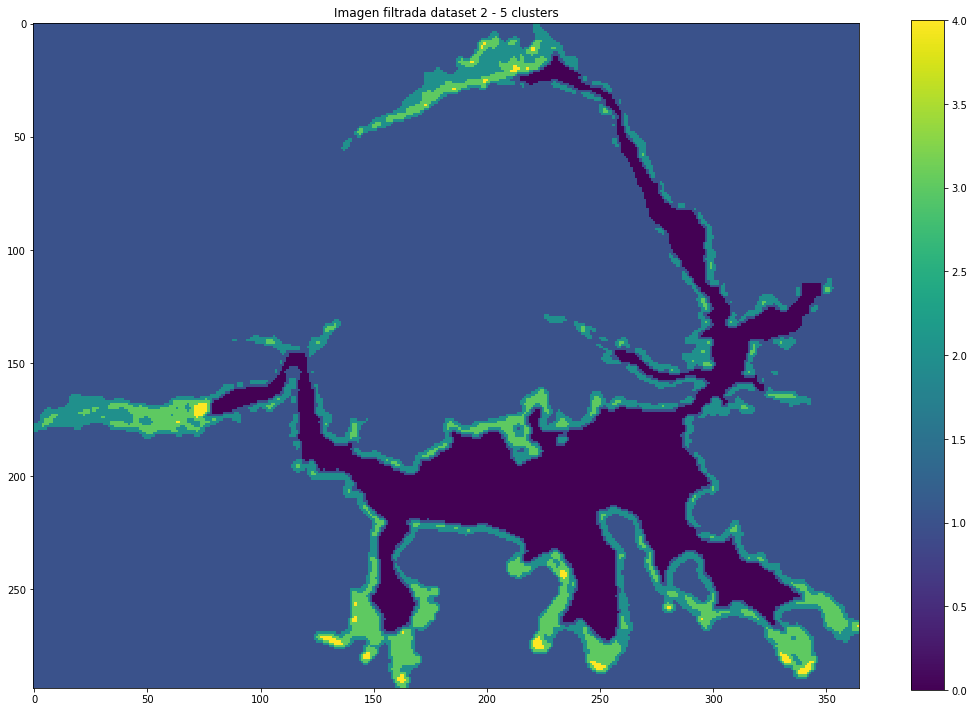

In [48]:
## Filtrado sobre el dataset de union y el modelo de clasificacion conjunto para la primera imagen

# Convertimos el cluster de resultados a formato imagen uint8 (por defecto es uint32, ahorra memoria)
cluster_2_IMG = clusters_2.reshape(bands[0].shape).astype('uint8')

# Filtro gausiano de 15x14
blurred_IMG_2 = cv.GaussianBlur(cluster_2_IMG, (5,5), 0)
                                 
plt.figure(figsize=(15,10))

plt.imshow(blurred_IMG_2) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Imagen filtrada dataset 2 - 5 clusters")

plt.tight_layout()

plt.show()


In [49]:
# El resultado simplifica (desenfoca) la imagen resultante de la clasificacion
# Ejecutamos Canny con la libreria cv

rawEdge_2 = cv.Canny(blurred_IMG_2, 2, 5, 3).astype("float").reshape(cluster_2_IMG.shape)

print("Formato imagen procesada con Canny: ", rawEdge_2.shape)


Formato imagen procesada con Canny:  (294, 365)


In [50]:
# En una sola línea de código obtuvimos el degradado,extrajimos los máximos locales y luego aplicamos el umbral con hiteresis para cada captura.

edges_2 = []
for edge in rawEdge_2:
    edge[edge == 0] = np.nan
    edges_2.append(edge)


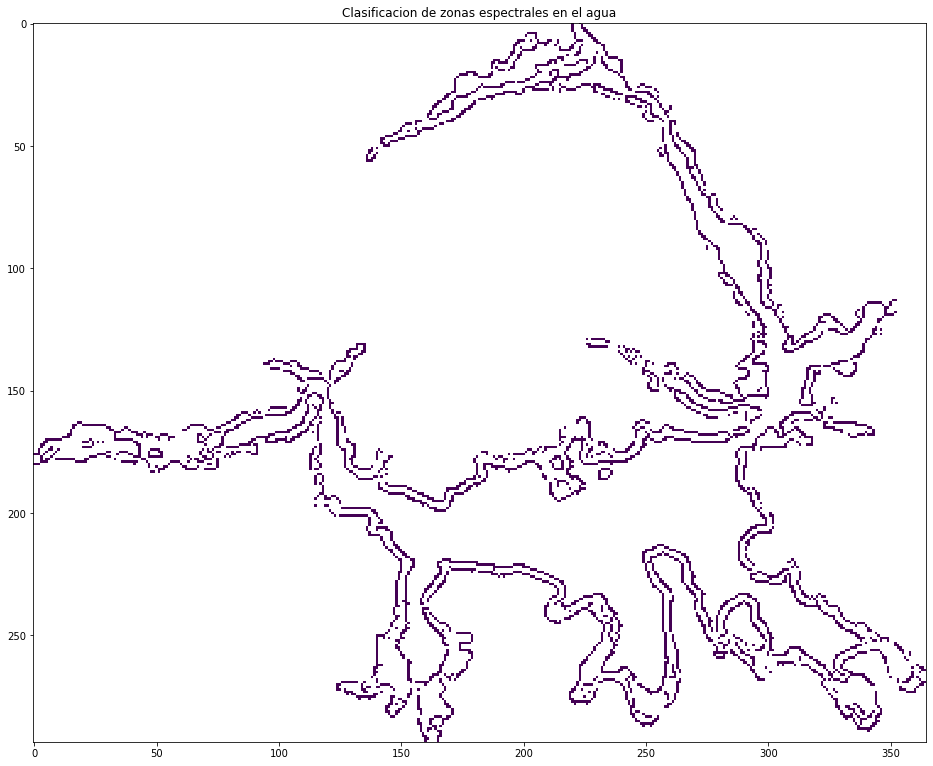

In [51]:
plt.figure(figsize=(16,30))

plt.imshow(edges_2)

plt.title('Clasificacion de zonas espectrales en el agua')

plt.show()

Podríamos realizar lo mismo para las escenas 3 y 4. Se deja al lector.

### Reconocimiento con el modelo conjunto

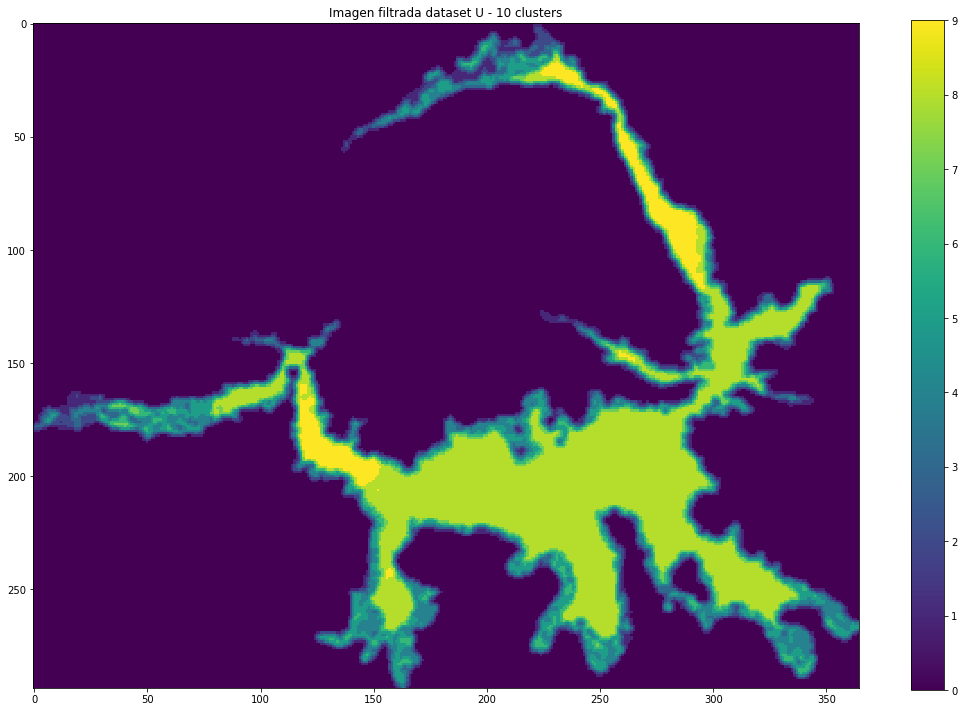

In [52]:
## Filtrado sobre el dataset de union y el modelo de clasificacion conjunto

# Convertimos el cluster de resultados a formato imagen uint8 (por defecto es uint32, ahorra memoria)
cluster_u_IMG = clusters_u.reshape(bands[0].shape).astype('uint8')

# Filtro gausiano de 15x14
blurred_IMG_u = cv.GaussianBlur(cluster_u_IMG, (5,5), 0)

# blurred_IMG_u = cv.bilateralFilter(cluster_u_IMG, 9, 75, 75) para resaltar mas los contornos
                                  
plt.figure(figsize=(15,10))

plt.imshow(blurred_IMG_u) # represento las etiquetas reformateadas como la imagen original

plt.colorbar() # imshow no maneja leyenda pero puede incluir colorbar

plt.title("Imagen filtrada dataset U - 10 clusters")

plt.tight_layout()

plt.show()


Una vez aplicado el filtro de reduccion de ruido, aplicamos el algoritmo de Canny.

En una sola instrucción, calcula los gradientes en la direccion horizontal y vertical para cada punto (kernel de Sobel). El gradiente es máximo en la dirección perpendicular a un borde.

Localizado el gradiente y su dirección a continuación elimina los pixeles que no cumplen la condicion de borde (gradiente maximo local, siguiendo una dirección que será perpendicular al degradado del gradiente).

Por último, aplica un valor umbral de arista (filtro de mínimo y máximo) para clasificar los bordes, descartando los que están por debajo o por encima del umbral. Basta con que un punto esté clasificado como borde y supere el límite máximo del umbral (borde seguro), para que todos los conectados con él sean considerados como una arista.

Para usar la funcion en cv, pasamos el nombre de la imagen de entrada (en formato numpy), y los valores mínimo y máximo del umbral. A continuación el tamaño de apertura o del kernel de Sobel usado para buscar los degradados en la imagen, por defecto 3.


In [53]:
# El resultado simplifica (desenfoca) la imagen resultante de la clasificacion
# Ejecutamos Canny con la libreria cv

rawEdge_u = cv.Canny(blurred_IMG_u, 2, 5, 3).astype("float").reshape(cluster_u_IMG.shape)

print("Formato imagen procesada con Canny: ", rawEdge_u.shape)


Formato imagen procesada con Canny:  (294, 365)


In [54]:
# En una sola línea de código obtuvimos el degradado,extrajimos los máximos locales y luego aplicamos el umbral con hiteresis para cada captura.

edges_u = []
for edge in rawEdge_u:
    edge[edge == 0] = np.nan
    edges_u.append(edge)


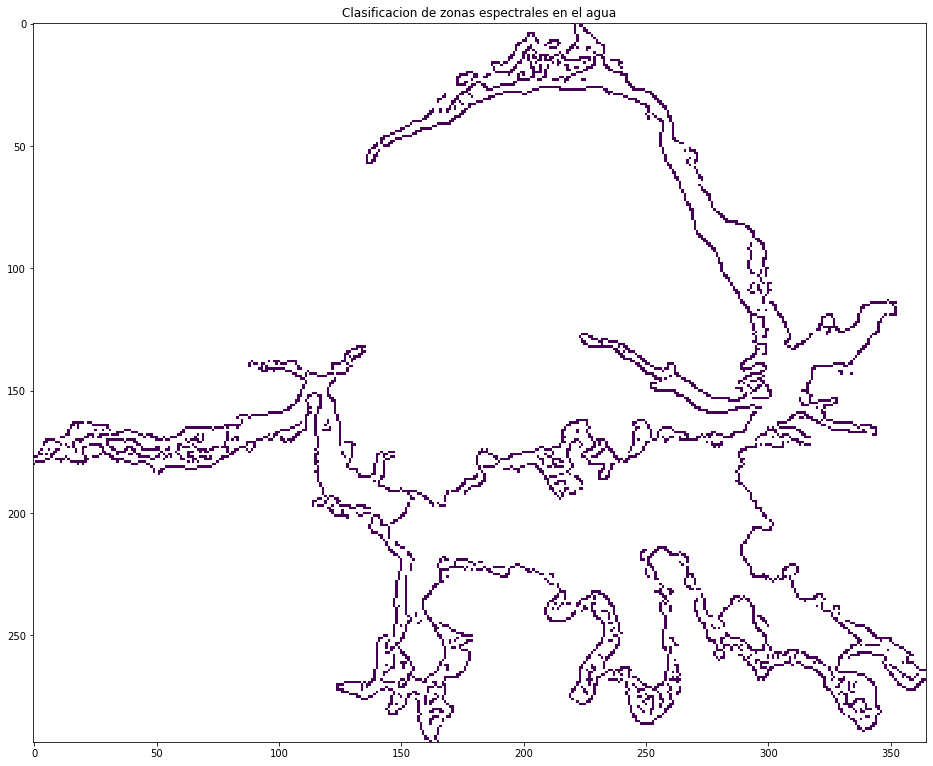

In [55]:
plt.figure(figsize=(16,30))

# plt.imshow(rgbImage2)

plt.imshow(edges_u)
#plt.imshow(edges[0], cmap = 'Set3_r')
#plt.imshow(edges[1], cmap = 'Set1')

plt.title('Clasificacion de zonas espectrales en el agua')

plt.show()

La variacion de firmas espectrales es adecuada para determinar donde colocar la instrumentacion para monitorizar el agua. Si es permanente se usará el mayor conjunto de datos posible (unión de datasets), pero para monitorizar situaciones concretas y detectar emergencias, habrá que utilizar los dataset más desfavorables de uno en uno.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


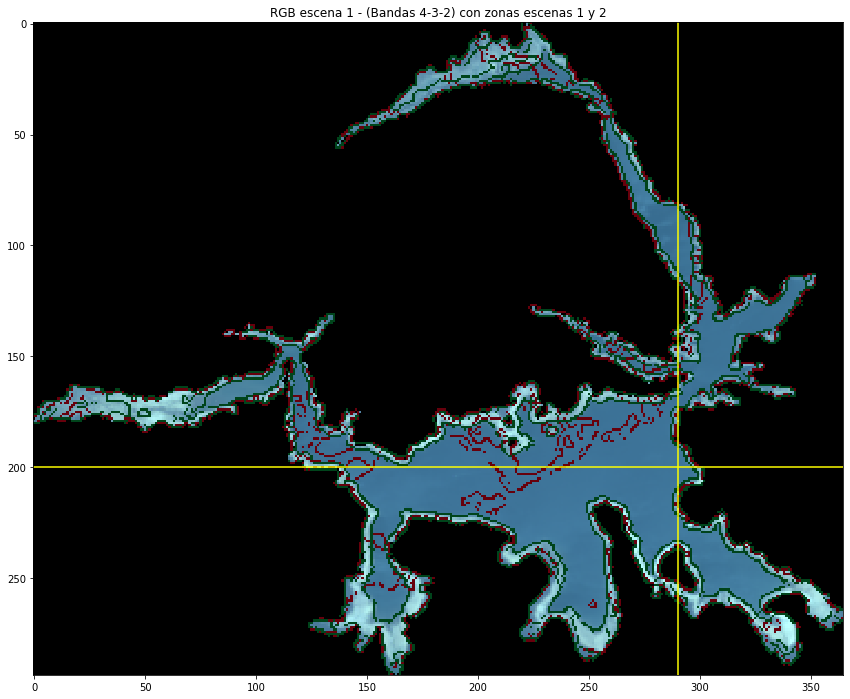

In [56]:
# Defino lineas de corte para firma espectral
firma_lh = 200
firma_lv = 290

# Muestro la composicion en banda visible de la primera escena para localizar linea de firma espectral
plt.figure(figsize=(16,12))

plt.imshow(rgbImage)

# Añado zonas espectrales de la primera y la segunda escena
plt.imshow(edges_1, cmap='Reds_r') # Primera escena
plt.imshow(edges_2, cmap='Greens_r') # Segunda escena

# Añado eje para marcar la posterior extraccion de las firmas en la imagen
plt.axhline(firma_lh, color='yellow')
plt.axvline(firma_lv, color='yellow')

plt.title("RGB escena 1 - (Bandas 4-3-2) con zonas escenas 1 y 2")

plt.show()


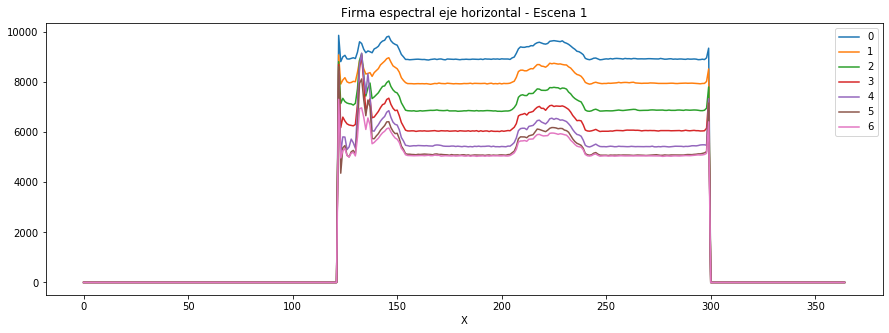

In [57]:
# Para extraer las firmas espectrales de estos perfiles,
# corto secciones en la matriz para cada eje y banda

plt.figure(figsize=(15,5))

# Para el eje de corte horizontal
for b in range(N_OPTICS_BANDS):
    horSection = bands[b][firma_lh,:]
    plt.plot(horSection, label=b)

plt.title("Firma espectral eje horizontal - Escena 1")
plt.xlabel("X")
plt.legend()

plt.show()

Para estimar la bondad de la clasificación de k-means, obtengo la variación del índice de elevación de la clorofila, calculado como el cociente entre las bandas B4 y B2 de Landsat8. Realmente este índice se definió para las bandas B5/B2 de Sentinel 2, y los numeradores no se corresponden exactamente, aunque están bastante próximos.

Si la variación de este índice es capaz de interpretar la variación de las zonas propuestas por k-means, el algoritmo no supervisado habrá interpretado correctamente las diferentes zonas de calidad del agua.

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


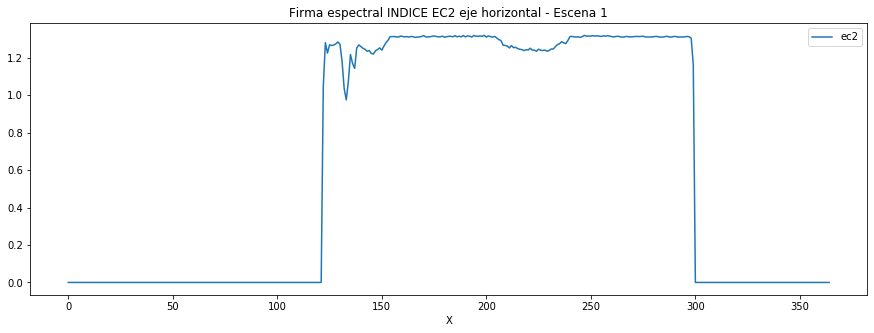

In [58]:
# Pruebo pseudo indice clorofila ec2 para firma espectral del perfil

# corto secciones en la matriz para cada eje y banda necesaria en el índice
horSection_b2 = bands[1][firma_lh,:]
horSection_b4 = bands[3][firma_lh,:]

# Calculo el indice
horSection_ec2 = horSection_b2/horSection_b4

# Elimino nan (divisiones por cero) asignando tambien cero
horSection_ec2[np.isnan(horSection_ec2)]=0

# Represento
plt.figure(figsize=(15,5))

plt.plot(horSection_ec2, label='ec2')

plt.title("Firma espectral INDICE EC2 eje horizontal - Escena 1")
plt.xlabel("X")
plt.legend()

plt.show()

Parece que las variaciones del indice, aunque débiles, han sido detectadas por K-Means y se corresponden con zonas diferentes. Este índice, aunque relativo a las bandas de Sentinel2 y no de Landsat8, indicaría elevaciones en el nivel de clorofila-a, es decir, de condiciones de eutrofización.

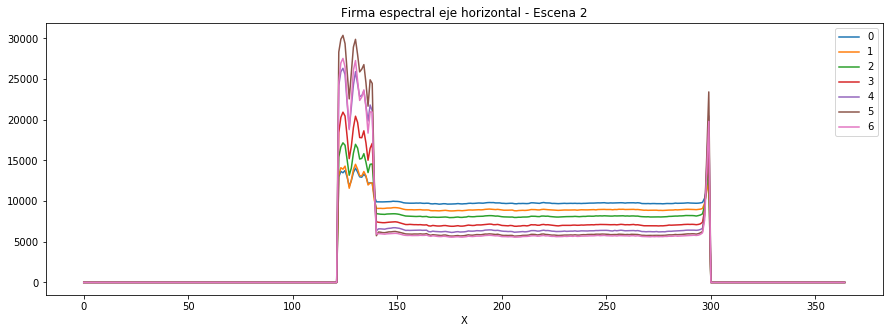

In [59]:
# Lo mismo, para la segunda escena

plt.figure(figsize=(15,5))

# Para el eje de corte horizontal
for b in range(N_OPTICS_BANDS):
    horSection = bands[b+N_OPTICS_BANDS][firma_lh,:]
    plt.plot(horSection, label=b)

plt.title("Firma espectral eje horizontal - Escena 2")
plt.xlabel("X")
plt.legend()

plt.show()

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


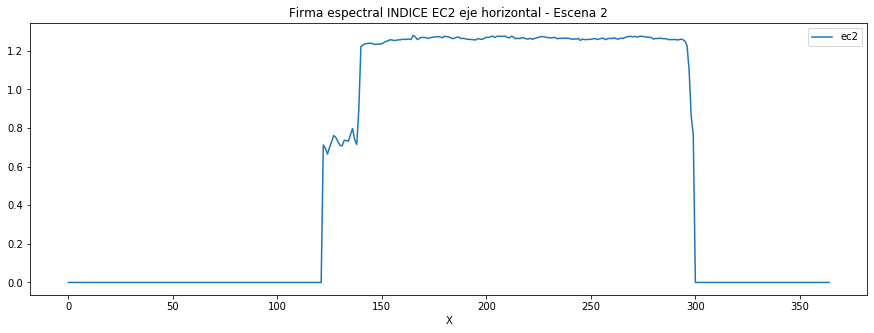

In [60]:
# Pruebo pseudo indice clorofila ec2 con banda azul para firma espectral del perfil

# corto secciones en la matriz para cada eje y banda necesaria en el índice
horSection_b2 = bands[1+N_OPTICS_BANDS][firma_lh,:]
horSection_b4 = bands[3+N_OPTICS_BANDS][firma_lh,:]

# Calculo el indice
horSection_ec2 = horSection_b2/horSection_b4

# Elimino nan (divisiones por cero) asignando tambien cero
horSection_ec2[np.isnan(horSection_ec2)]=0

# Represento
plt.figure(figsize=(15,5))

plt.plot(horSection_ec2, label='ec2')

plt.title("Firma espectral INDICE EC2 eje horizontal - Escena 2")
plt.xlabel("X")
plt.legend()

plt.show()

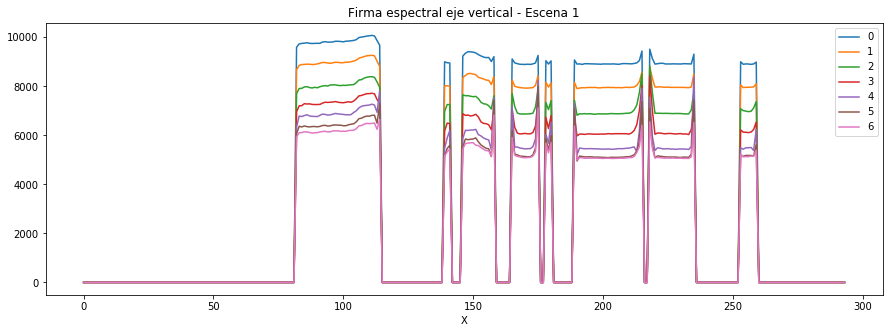

In [61]:
# De gigual manera, para el eje de corte vertical

plt.figure(figsize=(15,5))

# Para el eje de corte horizontal
for b in range(N_OPTICS_BANDS):
    verSection = bands[b][:, firma_lv]
    plt.plot(verSection, label=b)

plt.title("Firma espectral eje vertical - Escena 1")
plt.xlabel("X")
plt.legend()

plt.show()

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


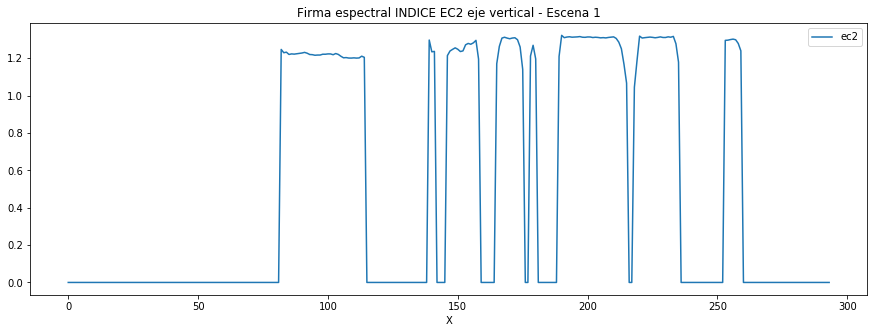

In [62]:
# Pruebo pseudo indice clorofila ec2 con banda azul para firma espectral del perfil

# corto secciones en la matriz para cada eje y banda necesaria en el índice
verSection_b2 = bands[1][:, firma_lv]
verSection_b4 = bands[3][:, firma_lv]

# Calculo el indice
verSection_ec2 = verSection_b2/verSection_b4

# Elimino nan (divisiones por cero) asignando tambien cero
verSection_ec2[np.isnan(verSection_ec2)]=0

# Represento
plt.figure(figsize=(15,5))

plt.plot(verSection_ec2, label='ec2')

plt.title("Firma espectral INDICE EC2 eje vertical - Escena 1")
plt.xlabel("X")
plt.legend()

plt.show()

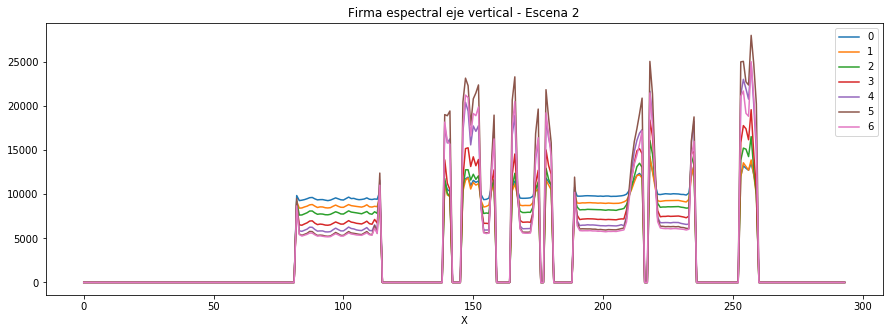

In [63]:
# De gigual manera, y para la segunda escena

plt.figure(figsize=(15,5))

# Para el eje de corte horizontal
for b in range(N_OPTICS_BANDS):
    verSection = bands[b+N_OPTICS_BANDS][:, firma_lv]
    plt.plot(verSection, label=b)

plt.title("Firma espectral eje vertical - Escena 2")
plt.xlabel("X")
plt.legend()

plt.show()

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


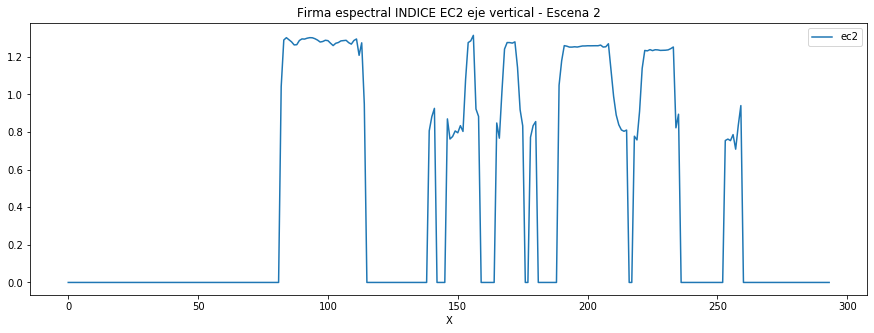

In [64]:
# Pruebo pseudo indice clorofila ec2 con banda azul para firma espectral del perfil

# corto secciones en la matriz para cada eje y banda necesaria en el índice
verSection_b2 = bands[1+N_OPTICS_BANDS][:, firma_lv]
verSection_b4 = bands[3+N_OPTICS_BANDS][:, firma_lv]

# Calculo el indice
verSection_ec2 = verSection_b2/verSection_b4

# Elimino nan (divisiones por cero) asignando tambien cero
verSection_ec2[np.isnan(verSection_ec2)]=0

# Represento
plt.figure(figsize=(15,5))

plt.plot(verSection_ec2, label='ec2')

plt.title("Firma espectral INDICE EC2 eje vertical - Escena 2")
plt.xlabel("X")
plt.legend()

plt.show()

Del análisis de la segunda escena se ven pocas variaciones en el eje horizontal, pero elevadas en el eje vertical, con grandes variaciones en el índice de clorofila, probablemente por la proliferación de algas en las zonas con menor profundidad y mayor soleamiento, y de hierba en las zonas húmedas sin cubrir por la lámina de agua.

A continuación, también podemos ver la firma espectral para un solo punto en todas las bandas como un diagrama de barras, y superponiéndolos, la evolución a lo largo de las escenas. Para que resulte útil, el punto debe estar en una zona representativa de las características a monitorizar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


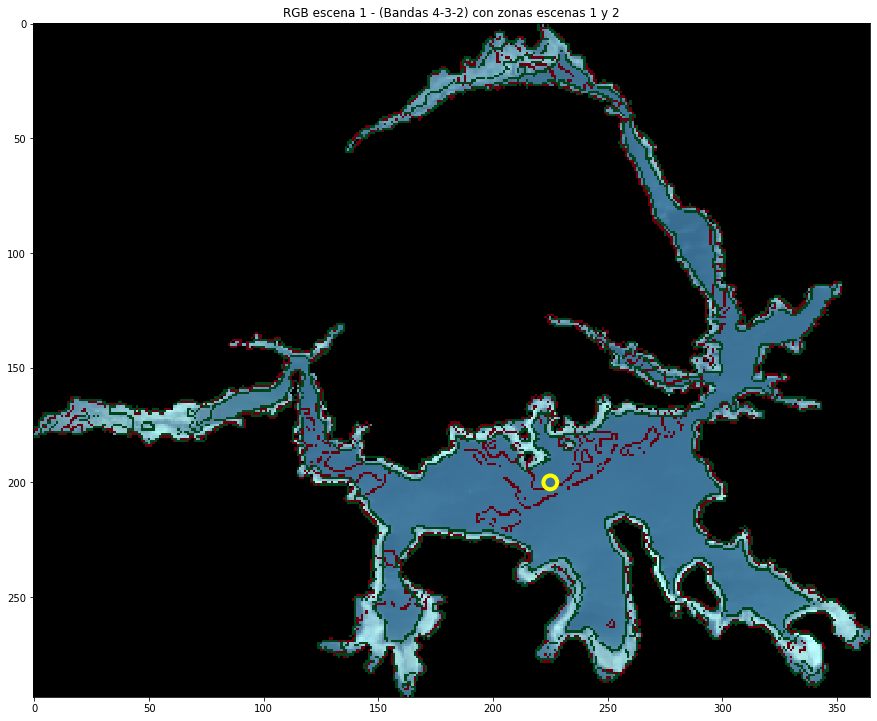

In [65]:
# Defino el punto de extraccion (coordenadas en pixeles) para firma espectral
firma_px = 225
firma_py = 200

# Lo incorporo como un objeto de libreria patches
from matplotlib.patches import Circle

# Muestro la composicion en banda visible de la primera escena para localizar linea de firma espectral
fig, ax = plt.subplots(1, figsize=(15,15)) # Debo poner subplots para poder añadir el punto

ax.imshow(rgbImage)

# Añado zonas espectrales de la primera y la segunda escena
ax.imshow(edges_1, cmap='Reds_r') # Primera escena
ax.imshow(edges_2, cmap='Greens_r') # Segunda escena

# Añado zona del punto a monitorizar
ax.add_patch(Circle((firma_px, firma_py),3, linewidth=4, edgecolor='yellow', facecolor='none'))

plt.title("RGB escena 1 - (Bandas 4-3-2) con zonas escenas 1 y 2")

plt.show()


In [66]:
# Compongo un cubo con la lista de matrices
bands_cube = np.array(bands)

print('Dimensiones del cubo:', bands_cube.shape)

# Extraigo en una nueva matriz los valores para ese punto existentes en todas las bandas

bands_pt = bands_cube[:, firma_py, firma_px] # Ojo, la forma esta invertida
    
print('Dimensiones de matriz para el punto:', bands_pt.shape)

# Compongo una lista de bandas para el gráfico de firma espectral
bandas_firma = ['1\nCosta','2\nAzul','3\nVerde','4\nRojo','5\nNIR','6\nSWIR1','7\nSWIR2']

Dimensiones del cubo: (28, 294, 365)
Dimensiones de matriz para el punto: (28,)


Eje x en valor 5000


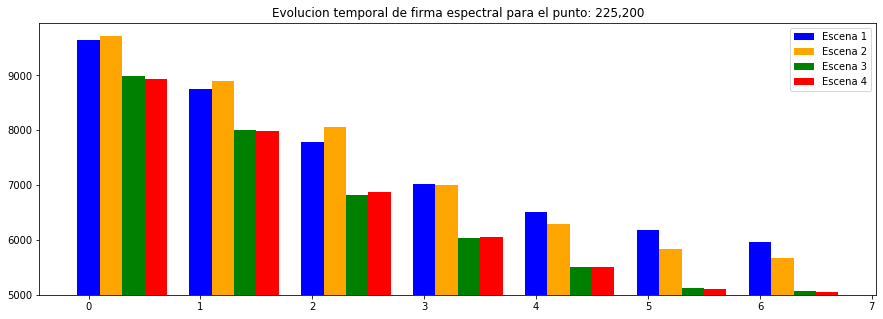

In [67]:
# Muestro la representacion de la firma de cada escena con un gráfico de barras

# Defino anchura de barras
ancho_bar = 0.2

# Creo lista con claves para etiquetas, y colores
colores = {'Escena 1':'blue', 'Escena 2': 'orange', 'Escena 3':'green', 'Escena 4': 'red'}
etiquetas = list(colores.keys()) # Defino las claves como lista

# Obtengo valor minimo del cojunto para ajustar eje
min_base = int(round(min(bands_pt)/1000)*1000) # Redondeado a miles
print("Eje x en valor",min_base)

# Defino tantas clases en el diabrama de barras como bandas
X = np.arange(len(bandas_firma))

# Defino la figura
plt.figure(figsize=(15,5))    

ax = plt.subplot(111)

# Bucle para recorrer el conjunto de datos
# Reparto los datos entre las escenas (esc = num escena)
for esc in range(int(bands_pt.shape[0]/N_OPTICS_BANDS)):
    # Segmento los datos en el numero de escenas
    inicio = esc*N_OPTICS_BANDS
    final = inicio + N_OPTICS_BANDS
    # X = np.arange(len(bandas_firma))
    ax.bar(X+(esc/5), bands_pt[inicio:final]-min_base, width=ancho_bar, bottom = min_base, color=colores[etiquetas[esc]], align='center')

# Inserto propiedades comunes al grafico
titulo = "Evolucion temporal de firma espectral para el punto: " + str(firma_px) + "," + str(firma_py)
plt.title(titulo)
plt.legend(etiquetas)

plt.show()

La variación entre las bandas cargadas con los números 1 y 3 (bandas 2 y 4 de Landsat8) correspondientes a las escenas 1/2 y las escenas 3/4 indicarían una variación en las condiciones de eutrofización del embalse.

Esta variación también se produce si consideramos la bandas cargada en el cubo en la cuarta capa (correspondiente a la banda 5 del Landsat8), que con la banda 4 ya vista se utilizaría para el cálculo del indice de vegetación NDVI.

Así mismo, los datos de la banda 1 (azul costero) cargada en la capa 0 del cubo, podría interpretar variaciones de turbidez en este punto.